# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
# !nvidia-smi

# Download and import required packages

In [3]:
# !pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
# !pip install --upgrade jupyter ipywidgets

In [4]:
# !git clone https://github.com/pytorch/fairseq.git
# !cd fairseq && git checkout 9a1c497
# !pip install --upgrade ./fairseq/

In [5]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [6]:
seed = 16
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [7]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
!rm -rf {prefix/'test'}

raw.en
raw.zh
test/
test/test.zh
test/test.en


## Language

In [8]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [9]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files

In [10]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [11]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/tmp2/ivy8792/ML/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/tmp2/ivy8792/ML/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [12]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## Split into train/valid

In [13]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [14]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [15]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/tmp2/ivy8792/ML/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [16]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/tmp2/ivy8792/ML/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/tmp2/ivy8792/ML/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/tmp2/ivy8792/ML/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/tmp2/ivy8792/ML/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/tmp2/ivy8792/ML/DATA/rawdata/ted2020/test.en exists. skipping spm_encode.
/tmp2/ivy8792/ML/DATA/rawdata/ted2020/test.zh exists. skipping spm_encode.


In [17]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## Binarize the data with fairseq

In [18]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Configuration for experiments

In [19]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr scalculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=1.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=100,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [20]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [21]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2022-03-23 17:58:48 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-03-23 17:58:48 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 10.761 GB ; name = GeForce RTX 2080 Ti                     
2022-03-23 17:58:48 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [22]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-03-23 17:58:49 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2022-03-23 17:58:49 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [23]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-03-23 17:58:49 | INFO | hw5.seq2seq | loading data for epoch 1
2022-03-23 17:58:49 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2022-03-23 17:58:49 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2022-03-23 17:58:49 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2022-03-23 17:58:49 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2022-03-23 17:58:49 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2022-03-23 17:58:49 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [24]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  35,   85,   14,    6,   13,  157,   74,   16,  405, 1390,   23,  412,
          15,    5,  257,  696,  235,  174,   22,   56,   12,  301,   95,  837,
        2269,   18,   63,   13,  459,  332,    8, 1468,   15,  426,  169,  376,
         986,    6,   15,  106,    4,   11,  122,  228,   52,  271,   29,  435,
         345,  120,  213,   89,   23,   76,  539,   57,   13, 1610, 2735,    7,
           2]),
 'target': tensor([1148,  493, 1078, 2706,    9, 2964,    4,   53,  628, 1866, 1272,  512,
           4,  637,  512,  239,  640,  852,   66, 1916,  840, 1067,    4, 2903,
         254, 1320, 1387, 2923,    4,    5,   78,  691, 2518, 1532,  280, 1322,
         369,  904,  403,   10, 2903,  254, 1320, 1387, 2923,    4,    5,   78,
         691, 2518, 1532,  280, 1322,  369,  904,  403,   10,    2])}
("Source: so there's a critical window of opportunity we have to make an "
 'important difference that can affect the lives of literally millions of '
 'people , 

# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [25]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-03-23 17:58:50 | WARNING | fairseq.tasks.fairseq_task | 2,502 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[1253, 3613, 1746, 2256, 221, 806, 1749, 3776, 2864, 1550]


{'id': tensor([1911]),
 'nsentences': 1,
 'ntokens': 12,
 'net_input': {'src_tokens': tensor([[  1,   1,   1,   1,   1,  55, 164, 336,  18,   4,  19, 414,   4,  32,
            60,  95,   5, 257, 696, 235, 174,   7,  32,   2]]),
  'src_lengths': tensor([19]),
  'prev_output_tokens': tensor([[   2,   40,  324,   90,    4,  110,    5,   81, 1164, 1365,   10,  111,
              1,    1,    1,    1]])},
 'target': tensor([[  40,  324,   90,    4,  110,    5,   81, 1164, 1365,   10,  111,    2,
             1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [26]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

# Encoder

- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      - encoder_layers is the number of layers for Encoder RNN
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask. 
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs: 
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2 
- Outputs: 
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore


In [27]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [28]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

# Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs: 
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2 
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs: 
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [29]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # project to vocab size
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [30]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [31]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
#     encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
#     decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [32]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=8,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=8,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [33]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [34]:
model = build_model(arch_args, task)
logger.info(model)

2022-03-23 17:59:04 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [35]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [36]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
#     lr = 0.001
    lr = d_model ** (-0.5) * min(step_num ** (-0.5), step_num * warmup_step ** (-1.5))
    return lr

In [37]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

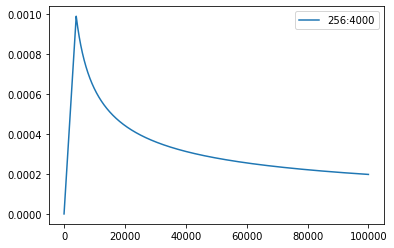

In [38]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [39]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        grad_norm.append(gnorm.item())
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [40]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [41]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [42]:
def validate_and_save(model, task, criterion, optimizer, epoch):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    
    save = False
    if bleu.score > best_bleu[0]:
        best_bleu[0] = bleu.score
        save = True
    
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        best_bleu[0] = stats['bleu']
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [43]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [44]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-03-23 17:59:22 | INFO | hw5.seq2seq | task: TranslationTask
2022-03-23 17:59:22 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-03-23 17:59:22 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-03-23 17:59:22 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-03-23 17:59:22 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-03-23 17:59:22 | INFO | hw5.seq2seq | num. model params: 16,741,376 (num. trained: 16,741,376)
2022-03-23 17:59:22 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [45]:
# config.start_epoch = 1
# config.max_epoch = 2

In [46]:
best_bleu = [0.0]
grad_norm = []

epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-03-23 17:59:22 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326700]
2022-03-23 17:59:22 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn/checkpoint_last.pt!


train epoch 1:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:03:02 | INFO | hw5.seq2seq | training loss: 7.2875
2022-03-23 18:03:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

/auto/master10/ivy8792/.local/share/virtualenvs/ivy8792-NO-Df_OY/lib/python3.6/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/auto/master10/ivy8792/.local/share/virtualenvs/ivy8792-NO-Df_OY/lib/python3.6/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torc

2022-03-23 18:03:33 | INFO | hw5.seq2seq | example source: but if you get the kiss in three days , well that's three days of jittery anticipation , the thrill of the wait .
2022-03-23 18:03:33 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我說: 「 有些年 , 有些年 , 用人 , 用人 , 用人 , 用 。
2022-03-23 18:03:33 | INFO | hw5.seq2seq | example reference: 但是如果你三天內才被親那就有三天緊張的預期 , 等待的快感
2022-03-23 18:03:33 | INFO | hw5.seq2seq | validation loss:	6.4606
2022-03-23 18:03:33 | INFO | hw5.seq2seq | BLEU = 0.44 15.2/1.4/0.2/0.0 (BP = 0.669 ratio = 0.713 hyp_len = 77437 ref_len = 108572)
2022-03-23 18:03:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint1.pt
2022-03-23 18:03:33 | INFO | hw5.seq2seq | end of epoch 1


train epoch 2:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:07:12 | INFO | hw5.seq2seq | training loss: 5.8874
2022-03-23 18:07:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:07:42 | INFO | hw5.seq2seq | example source: you can see where the oil is concentrated at the surface , and then it is attacked , because they don't want the evidence , in my opinion .
2022-03-23 18:07:42 | INFO | hw5.seq2seq | example hypothesis: 你可以看到 , 地球上 , 空氣 , 直到它 , 因為他們不想 , 因為他們不想的 。
2022-03-23 18:07:42 | INFO | hw5.seq2seq | example reference: 你是可以看到海上的浮油集中在表面的地方 , 但他們已經動了手腳 。 我的看法是 , 他們根本不想要留下任何證據
2022-03-23 18:07:42 | INFO | hw5.seq2seq | validation loss:	5.2497
2022-03-23 18:07:42 | INFO | hw5.seq2seq | BLEU = 4.86 33.0/10.7/3.8/1.4 (BP = 0.742 ratio = 0.770 hyp_len = 83633 ref_len = 108572)
2022-03-23 18:07:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint2.pt
2022-03-23 18:07:43 | INFO | hw5.seq2seq | end of epoch 2


train epoch 3:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:11:23 | INFO | hw5.seq2seq | training loss: 5.0925
2022-03-23 18:11:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:11:56 | INFO | hw5.seq2seq | example source: and they're looking at how many of the people they've inducted are available each hour next week .
2022-03-23 18:11:56 | INFO | hw5.seq2seq | example hypothesis: 他們在研究中有多少人 , 他們在一星期間有多少人在下一星期 , 每個星期都很可怕 。
2022-03-23 18:11:56 | INFO | hw5.seq2seq | example reference: 他們想知道等到下星期 , 每個鐘點能找到幾個培訓員工上班 。
2022-03-23 18:11:56 | INFO | hw5.seq2seq | validation loss:	4.7482
2022-03-23 18:11:56 | INFO | hw5.seq2seq | BLEU = 9.80 36.2/14.6/6.3/2.8 (BP = 1.000 ratio = 1.069 hyp_len = 116111 ref_len = 108572)
2022-03-23 18:11:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint3.pt
2022-03-23 18:11:57 | INFO | hw5.seq2seq | end of epoch 3


train epoch 4:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:15:36 | INFO | hw5.seq2seq | training loss: 4.6891
2022-03-23 18:15:36 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:16:09 | INFO | hw5.seq2seq | example source: so that's the same concept .
2022-03-23 18:16:09 | INFO | hw5.seq2seq | example hypothesis: 這是同樣的概念 。
2022-03-23 18:16:09 | INFO | hw5.seq2seq | example reference: 這是完全相同的概念但有時候 , 經濟學家也會搞錯
2022-03-23 18:16:09 | INFO | hw5.seq2seq | validation loss:	4.3445
2022-03-23 18:16:09 | INFO | hw5.seq2seq | BLEU = 13.14 45.7/20.6/10.1/5.2 (BP = 0.881 ratio = 0.887 hyp_len = 96346 ref_len = 108572)
2022-03-23 18:16:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint4.pt
2022-03-23 18:16:09 | INFO | hw5.seq2seq | end of epoch 4


train epoch 5:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:19:49 | INFO | hw5.seq2seq | training loss: 4.3994
2022-03-23 18:19:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:20:18 | INFO | hw5.seq2seq | example source: a mother finishes setting the table for dinner .
2022-03-23 18:20:18 | INFO | hw5.seq2seq | example hypothesis: 一位母親定義了晚餐桌的桌子 。
2022-03-23 18:20:18 | INFO | hw5.seq2seq | example reference: 一個媽媽佈置好了晚餐的餐桌 。
2022-03-23 18:20:18 | INFO | hw5.seq2seq | validation loss:	4.1159
2022-03-23 18:20:18 | INFO | hw5.seq2seq | BLEU = 15.80 49.7/23.8/12.2/6.6 (BP = 0.899 ratio = 0.904 hyp_len = 98133 ref_len = 108572)
2022-03-23 18:20:19 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint5.pt
2022-03-23 18:20:19 | INFO | hw5.seq2seq | end of epoch 5


train epoch 6:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:24:00 | INFO | hw5.seq2seq | training loss: 4.1905
2022-03-23 18:24:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:24:33 | INFO | hw5.seq2seq | example source: and mother got time to read for me .
2022-03-23 18:24:33 | INFO | hw5.seq2seq | example hypothesis: 母親有時間來閱讀我 。
2022-03-23 18:24:33 | INFO | hw5.seq2seq | example reference: 而媽媽有空可以念給我聽
2022-03-23 18:24:33 | INFO | hw5.seq2seq | validation loss:	3.9494
2022-03-23 18:24:33 | INFO | hw5.seq2seq | BLEU = 18.12 50.4/25.0/13.4/7.5 (BP = 0.961 ratio = 0.961 hyp_len = 104371 ref_len = 108572)
2022-03-23 18:24:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint6.pt
2022-03-23 18:24:33 | INFO | hw5.seq2seq | end of epoch 6


train epoch 7:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:28:15 | INFO | hw5.seq2seq | training loss: 4.0282
2022-03-23 18:28:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:28:49 | INFO | hw5.seq2seq | example source: another adaptation would be this piece .
2022-03-23 18:28:49 | INFO | hw5.seq2seq | example hypothesis: 另一個適應性會是這個作品 。
2022-03-23 18:28:49 | INFO | hw5.seq2seq | example reference: 另一個改編是這個作品
2022-03-23 18:28:49 | INFO | hw5.seq2seq | validation loss:	3.8338
2022-03-23 18:28:49 | INFO | hw5.seq2seq | BLEU = 19.35 53.8/27.7/15.1/8.7 (BP = 0.920 ratio = 0.923 hyp_len = 100239 ref_len = 108572)
2022-03-23 18:28:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint7.pt
2022-03-23 18:28:49 | INFO | hw5.seq2seq | end of epoch 7


train epoch 8:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:32:27 | INFO | hw5.seq2seq | training loss: 3.9174
2022-03-23 18:32:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:32:46 | INFO | hw5.seq2seq | example source: i had really misunderstood the technology .
2022-03-23 18:32:46 | INFO | hw5.seq2seq | example hypothesis: 我真的誤解了這項技術 。
2022-03-23 18:32:46 | INFO | hw5.seq2seq | example reference: 我當時誤解了那些技術
2022-03-23 18:32:46 | INFO | hw5.seq2seq | validation loss:	3.7586
2022-03-23 18:32:46 | INFO | hw5.seq2seq | BLEU = 20.25 55.6/29.3/16.3/9.6 (BP = 0.901 ratio = 0.905 hyp_len = 98286 ref_len = 108572)
2022-03-23 18:32:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint8.pt
2022-03-23 18:32:47 | INFO | hw5.seq2seq | end of epoch 8


train epoch 9:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:36:16 | INFO | hw5.seq2seq | training loss: 3.8343
2022-03-23 18:36:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:36:40 | INFO | hw5.seq2seq | example source: i transformed my unassuming school library into a laboratory and my peers into lab rats .
2022-03-23 18:36:40 | INFO | hw5.seq2seq | example hypothesis: 我轉變了不愉快的學校圖書館 , 進入實驗室 , 和我的同儕進入實驗室的老鼠 。
2022-03-23 18:36:40 | INFO | hw5.seq2seq | example reference: 我把平凡無奇的學校圖書館變成了實驗室 , 把同學變成實驗室的白老鼠 。
2022-03-23 18:36:40 | INFO | hw5.seq2seq | validation loss:	3.7008
2022-03-23 18:36:40 | INFO | hw5.seq2seq | BLEU = 20.96 53.4/28.2/15.7/9.2 (BP = 0.969 ratio = 0.970 hyp_len = 105287 ref_len = 108572)
2022-03-23 18:36:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint9.pt
2022-03-23 18:36:40 | INFO | hw5.seq2seq | end of epoch 9


train epoch 10:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:40:09 | INFO | hw5.seq2seq | training loss: 3.7677
2022-03-23 18:40:09 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:40:29 | INFO | hw5.seq2seq | example source: " are they dating ? are they not dating ? "
2022-03-23 18:40:29 | INFO | hw5.seq2seq | example hypothesis: 「 他們在約會嗎 ? 他們不是約會嗎 ? 」
2022-03-23 18:40:29 | INFO | hw5.seq2seq | example reference: 「 他們是否在約會 ? 」
2022-03-23 18:40:29 | INFO | hw5.seq2seq | validation loss:	3.6634
2022-03-23 18:40:29 | INFO | hw5.seq2seq | BLEU = 20.83 57.1/30.6/17.3/10.3 (BP = 0.882 ratio = 0.889 hyp_len = 96474 ref_len = 108572)
2022-03-23 18:40:29 | INFO | hw5.seq2seq | end of epoch 10


train epoch 11:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:44:00 | INFO | hw5.seq2seq | training loss: 3.7156
2022-03-23 18:44:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:44:24 | INFO | hw5.seq2seq | example source: in each shot glass is a different scented oil .
2022-03-23 18:44:24 | INFO | hw5.seq2seq | example hypothesis: 在每一個槍玻璃中 , 都是不同的石油 。
2022-03-23 18:44:24 | INFO | hw5.seq2seq | example reference: 每個烈酒杯裡有不同的香氛精油
2022-03-23 18:44:24 | INFO | hw5.seq2seq | validation loss:	3.6253
2022-03-23 18:44:24 | INFO | hw5.seq2seq | BLEU = 22.14 53.8/28.7/16.2/9.6 (BP = 1.000 ratio = 1.001 hyp_len = 108670 ref_len = 108572)
2022-03-23 18:44:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint11.pt
2022-03-23 18:44:24 | INFO | hw5.seq2seq | end of epoch 11


train epoch 12:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:47:59 | INFO | hw5.seq2seq | training loss: 3.6733
2022-03-23 18:47:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:48:20 | INFO | hw5.seq2seq | example source: that means thoughts will come into your mind and you need to let them go out of your mind .
2022-03-23 18:48:20 | INFO | hw5.seq2seq | example hypothesis: 也就是說 , 思想會出現在你腦海裡 , 你必須讓它們離開你腦海 。
2022-03-23 18:48:20 | INFO | hw5.seq2seq | example reference: 也就是說 , 想法會自然流入你的頭腦 , 你只要把它們表達出來 。
2022-03-23 18:48:20 | INFO | hw5.seq2seq | validation loss:	3.5795
2022-03-23 18:48:20 | INFO | hw5.seq2seq | BLEU = 22.39 56.9/31.0/17.8/10.7 (BP = 0.930 ratio = 0.932 hyp_len = 101188 ref_len = 108572)
2022-03-23 18:48:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint12.pt
2022-03-23 18:48:20 | INFO | hw5.seq2seq | end of epoch 12


train epoch 13:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:51:50 | INFO | hw5.seq2seq | training loss: 3.6331
2022-03-23 18:51:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:52:12 | INFO | hw5.seq2seq | example source: you know , my friends , i look at this photograph and i have to ask myself , you know , i think i've seen this somewhere before .
2022-03-23 18:52:12 | INFO | hw5.seq2seq | example hypothesis: 你知道的 , 我的朋友 , 我看著這張照片 , 我必須問自己 , 你知道嗎 , 我想我曾經看過這張照片 。
2022-03-23 18:52:12 | INFO | hw5.seq2seq | example reference: 你知道嗎 , 我的朋友們 , 每當我看著這張照片時 , 我都要問我自己 , 我是不是以前在什麼地方見過這景象 。
2022-03-23 18:52:12 | INFO | hw5.seq2seq | validation loss:	3.5653
2022-03-23 18:52:12 | INFO | hw5.seq2seq | BLEU = 22.70 56.1/30.4/17.4/10.5 (BP = 0.959 ratio = 0.960 hyp_len = 104210 ref_len = 108572)
2022-03-23 18:52:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint13.pt
2022-03-23 18:52:12 | INFO | hw5.seq2seq | end of epoch 13


train epoch 14:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:55:41 | INFO | hw5.seq2seq | training loss: 3.6040
2022-03-23 18:55:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:56:01 | INFO | hw5.seq2seq | example source: in peru , they call it the peruvian décima , because the décima becomes so integrated into our traditions , that if someone asks , people from each place are completely convinced that the décima was invented in their country .
2022-03-23 18:56:01 | INFO | hw5.seq2seq | example hypothesis: 在秘魯 , 他們稱之為 「 秘魯décima 」 , 因為décima對我們的傳統非常整合 , 如果有人問 , 每個地方的人都完全相信décima在他們的國家發明了 。
2022-03-23 18:56:01 | INFO | hw5.seq2seq | example reference: 在秘魯 , 它被稱為 「 秘魯décima 」 , 因為décima與我們的傳統深深結合 , 如果被問起 , 每個地方的人都深信décima是他們的國家發明的 。
2022-03-23 18:56:01 | INFO | hw5.seq2seq | validation loss:	3.5352
2022-03-23 18:56:01 | INFO | hw5.seq2seq | BLEU = 22.52 58.0/31.8/18.3/11.1 (BP = 0.911 ratio = 0.915 hyp_len = 99316 ref_len = 108572)
2022-03-23 18:56:01 | INFO | hw5.seq2seq | end of epoch 14


train epoch 15:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 18:59:31 | INFO | hw5.seq2seq | training loss: 3.5742
2022-03-23 18:59:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 18:59:53 | INFO | hw5.seq2seq | example source: at one end , the basilar membrane is stiff , vibrating only in response to short wavelength , highfrequency sounds .
2022-03-23 18:59:53 | INFO | hw5.seq2seq | example hypothesis: 一端 , 巴西膜是硬的 , 只對短波的波長、高頻頻的聲音振動 。
2022-03-23 18:59:53 | INFO | hw5.seq2seq | example reference: 基底膜的一端是硬的 , 只有在遇到短波長、高頻率的聲音時才會震動 。
2022-03-23 18:59:53 | INFO | hw5.seq2seq | validation loss:	3.5196
2022-03-23 18:59:53 | INFO | hw5.seq2seq | BLEU = 22.99 57.9/31.8/18.4/11.2 (BP = 0.927 ratio = 0.930 hyp_len = 100926 ref_len = 108572)
2022-03-23 18:59:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint15.pt
2022-03-23 18:59:54 | INFO | hw5.seq2seq | end of epoch 15


train epoch 16:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:03:23 | INFO | hw5.seq2seq | training loss: 3.5484
2022-03-23 19:03:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:03:44 | INFO | hw5.seq2seq | example source: i just left it , i don't want to think about that place again .
2022-03-23 19:03:44 | INFO | hw5.seq2seq | example hypothesis: 我只剩下它 , 我不想再次思考那個地方 。
2022-03-23 19:03:44 | INFO | hw5.seq2seq | example reference: 我剛剛離開 , 不願再想到那個地方 。
2022-03-23 19:03:44 | INFO | hw5.seq2seq | validation loss:	3.5034
2022-03-23 19:03:44 | INFO | hw5.seq2seq | BLEU = 23.08 57.7/31.7/18.4/11.2 (BP = 0.931 ratio = 0.933 hyp_len = 101344 ref_len = 108572)
2022-03-23 19:03:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint16.pt
2022-03-23 19:03:45 | INFO | hw5.seq2seq | end of epoch 16


train epoch 17:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:07:15 | INFO | hw5.seq2seq | training loss: 3.5275
2022-03-23 19:07:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:07:36 | INFO | hw5.seq2seq | example source: well , first we need to figure out what they are .
2022-03-23 19:07:36 | INFO | hw5.seq2seq | example hypothesis: 首先 , 我們需要找出它們是什麼 。
2022-03-23 19:07:36 | INFO | hw5.seq2seq | example reference: 首先我們得找出它們是什麼 ,
2022-03-23 19:07:36 | INFO | hw5.seq2seq | validation loss:	3.4867
2022-03-23 19:07:36 | INFO | hw5.seq2seq | BLEU = 23.13 58.4/32.2/18.7/11.4 (BP = 0.920 ratio = 0.923 hyp_len = 100264 ref_len = 108572)
2022-03-23 19:07:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint17.pt
2022-03-23 19:07:37 | INFO | hw5.seq2seq | end of epoch 17


train epoch 18:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:11:08 | INFO | hw5.seq2seq | training loss: 3.5069
2022-03-23 19:11:08 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:11:28 | INFO | hw5.seq2seq | example source: if somebody is annoying me , being rude: stand on my right side .
2022-03-23 19:11:28 | INFO | hw5.seq2seq | example hypothesis: 如果有人很煩我 , 很魯德:站在右邊 。
2022-03-23 19:11:28 | INFO | hw5.seq2seq | example reference: 如果有人很煩、對我沒禮貌我就讓他們站在我的右邊
2022-03-23 19:11:28 | INFO | hw5.seq2seq | validation loss:	3.4778
2022-03-23 19:11:28 | INFO | hw5.seq2seq | BLEU = 23.24 59.1/32.8/19.0/11.7 (BP = 0.907 ratio = 0.911 hyp_len = 98958 ref_len = 108572)
2022-03-23 19:11:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint18.pt
2022-03-23 19:11:29 | INFO | hw5.seq2seq | end of epoch 18


train epoch 19:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:15:01 | INFO | hw5.seq2seq | training loss: 3.4905
2022-03-23 19:15:01 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:15:22 | INFO | hw5.seq2seq | example source: the maersk line looked at their competition and saw that everybody who is in shipping thinks time is money .
2022-03-23 19:15:22 | INFO | hw5.seq2seq | example hypothesis: 馬克線看著他們的競爭 , 看到所有在運輸時期的人都認為時間是金錢 。
2022-03-23 19:15:22 | INFO | hw5.seq2seq | example reference: 快桅航運公司審視了他們的競爭者 , 看到船運業中所有人都認為:時間就是金錢
2022-03-23 19:15:22 | INFO | hw5.seq2seq | validation loss:	3.4640
2022-03-23 19:15:22 | INFO | hw5.seq2seq | BLEU = 23.78 57.5/31.8/18.5/11.3 (BP = 0.956 ratio = 0.957 hyp_len = 103930 ref_len = 108572)
2022-03-23 19:15:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint19.pt
2022-03-23 19:15:22 | INFO | hw5.seq2seq | end of epoch 19


train epoch 20:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:18:53 | INFO | hw5.seq2seq | training loss: 3.4712
2022-03-23 19:18:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:19:13 | INFO | hw5.seq2seq | example source: i was determined to change my relationship with the cancer and i was determined to learn more about my cancer before doing anything as drastic as a surgery .
2022-03-23 19:19:13 | INFO | hw5.seq2seq | example hypothesis: 我被判定要改變我與癌症的關係 , 我決定要學更多關於我的癌症 , 做任何戲劇化的手術 。
2022-03-23 19:19:13 | INFO | hw5.seq2seq | example reference: 決心要改變我跟癌症的關係要做重要的決定前例如動手術決心要先多了解自己的腫瘤
2022-03-23 19:19:13 | INFO | hw5.seq2seq | validation loss:	3.4511
2022-03-23 19:19:13 | INFO | hw5.seq2seq | BLEU = 23.64 58.7/32.7/19.1/11.7 (BP = 0.924 ratio = 0.927 hyp_len = 100648 ref_len = 108572)
2022-03-23 19:19:13 | INFO | hw5.seq2seq | end of epoch 20


train epoch 21:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:22:46 | INFO | hw5.seq2seq | training loss: 3.4587
2022-03-23 19:22:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:23:08 | INFO | hw5.seq2seq | example source: and the basic idea of kin selection is that , if an animal feels compassion for a close relative , and this compassion leads the animal to help the relative , then , in the end , the compassion actually winds up helping the genes underlying the compassion itself .
2022-03-23 19:23:08 | INFO | hw5.seq2seq | example hypothesis: 而kin選舉的基本概念是 , 如果動物對近親有同情心 , 同情心會導致動物幫助親戚 , 最終 , 同情心會讓基因在同情心下受益 。
2022-03-23 19:23:08 | INFO | hw5.seq2seq | example reference: 親屬選擇的基本想法是 , 如果一個動物對近親有同情的感覺 , 而且這種同情的感覺使這個動物去幫助牠的親戚 , 最终 , 這種同情心最終幫助了隱含在這同情心裡的基因 。
2022-03-23 19:23:08 | INFO | hw5.seq2seq | validation loss:	3.4419
2022-03-23 19:23:08 | INFO | hw5.seq2seq | BLEU = 23.89 58.2/32.4/18.8/11.6 (BP = 0.943 ratio = 0.945 hyp_len = 102597 ref_len = 108572)
2022-03-23 19:23:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint21.pt
2022-03-23 19:23:08 | INFO | hw5.seq2seq | end of epoch 21


train epoch 22:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:26:37 | INFO | hw5.seq2seq | training loss: 3.4426
2022-03-23 19:26:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:26:58 | INFO | hw5.seq2seq | example source: the story goes that participants were prepared to give what they believed to be fatal electric shocks to a fellow participant when they got a question wrong , just because someone in a white coat told them to .
2022-03-23 19:26:58 | INFO | hw5.seq2seq | example hypothesis: 故事是 , 受試者準備好要給予他們所相信的正式電擊 , 給予受試者一個受試者一個錯誤的問題 , 只是因為有一位白色的警察告訴他們 。
2022-03-23 19:26:58 | INFO | hw5.seq2seq | example reference: 這邊平均是3.42歲 , 所以我們明白了: 「 每個人都需要個糖爸爸 。 」 我們就從伴侶的話題轉移到 , 如何在籃球或足球等運動得分的這個話題吧 。
2022-03-23 19:26:58 | INFO | hw5.seq2seq | validation loss:	3.4407
2022-03-23 19:26:58 | INFO | hw5.seq2seq | BLEU = 24.43 57.9/32.2/18.8/11.6 (BP = 0.967 ratio = 0.968 hyp_len = 105091 ref_len = 108572)
2022-03-23 19:26:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint22.pt
2022-03-23 19:26:59 | INFO | hw5.seq2seq | end of epoch 22


train epoch 23:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:30:27 | INFO | hw5.seq2seq | training loss: 3.4310
2022-03-23 19:30:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:30:51 | INFO | hw5.seq2seq | example source: db: will you sell the farm ?
2022-03-23 19:30:51 | INFO | hw5.seq2seq | example hypothesis: db:你會賣農場嗎 ?
2022-03-23 19:30:51 | INFO | hw5.seq2seq | example reference: 妳會賣掉農場嗎 ?
2022-03-23 19:30:51 | INFO | hw5.seq2seq | validation loss:	3.4338
2022-03-23 19:30:51 | INFO | hw5.seq2seq | BLEU = 24.28 57.7/32.1/18.7/11.6 (BP = 0.964 ratio = 0.965 hyp_len = 104760 ref_len = 108572)
2022-03-23 19:30:51 | INFO | hw5.seq2seq | end of epoch 23


train epoch 24:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:34:21 | INFO | hw5.seq2seq | training loss: 3.4194
2022-03-23 19:34:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:34:41 | INFO | hw5.seq2seq | example source: i don't know i prefer to test their beliefs , scientifically .
2022-03-23 19:34:41 | INFO | hw5.seq2seq | example hypothesis: 我不知道我偏好在科學上測試他們的信念 。
2022-03-23 19:34:41 | INFO | hw5.seq2seq | example reference: 我不知道 。 但我可以使用科學方法把他們的信念拿來實驗
2022-03-23 19:34:41 | INFO | hw5.seq2seq | validation loss:	3.4155
2022-03-23 19:34:41 | INFO | hw5.seq2seq | BLEU = 23.76 59.4/33.1/19.3/11.9 (BP = 0.916 ratio = 0.919 hyp_len = 99803 ref_len = 108572)
2022-03-23 19:34:41 | INFO | hw5.seq2seq | end of epoch 24


train epoch 25:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:38:14 | INFO | hw5.seq2seq | training loss: 3.4077
2022-03-23 19:38:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:38:35 | INFO | hw5.seq2seq | example source: in this scan pass , in green here , are twoyearolds with autism .
2022-03-23 19:38:35 | INFO | hw5.seq2seq | example hypothesis: 在這個掃描中 , 在綠色這裡 , 有兩歲的自閉症 。
2022-03-23 19:38:35 | INFO | hw5.seq2seq | example reference: 綠色的這些則是有自閉症的孩子做的事
2022-03-23 19:38:35 | INFO | hw5.seq2seq | validation loss:	3.4130
2022-03-23 19:38:35 | INFO | hw5.seq2seq | BLEU = 24.00 59.2/33.1/19.4/12.0 (BP = 0.925 ratio = 0.927 hyp_len = 100691 ref_len = 108572)
2022-03-23 19:38:35 | INFO | hw5.seq2seq | end of epoch 25


train epoch 26:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:42:12 | INFO | hw5.seq2seq | training loss: 3.3955
2022-03-23 19:42:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:42:37 | INFO | hw5.seq2seq | example source: we are only happy when things are in order .
2022-03-23 19:42:37 | INFO | hw5.seq2seq | example hypothesis: 只有當事情順利時 , 我們才快樂 。
2022-03-23 19:42:37 | INFO | hw5.seq2seq | example reference: 一切井井有條的時候我們才會快樂
2022-03-23 19:42:37 | INFO | hw5.seq2seq | validation loss:	3.4061
2022-03-23 19:42:37 | INFO | hw5.seq2seq | BLEU = 23.82 59.7/33.4/19.5/12.0 (BP = 0.910 ratio = 0.914 hyp_len = 99239 ref_len = 108572)
2022-03-23 19:42:37 | INFO | hw5.seq2seq | end of epoch 26


train epoch 27:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:46:08 | INFO | hw5.seq2seq | training loss: 3.3863
2022-03-23 19:46:08 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:46:30 | INFO | hw5.seq2seq | example source: let's look at that .
2022-03-23 19:46:30 | INFO | hw5.seq2seq | example hypothesis: 讓我們來看看這一點 。
2022-03-23 19:46:30 | INFO | hw5.seq2seq | example reference: 我們來看這裡
2022-03-23 19:46:30 | INFO | hw5.seq2seq | validation loss:	3.4054
2022-03-23 19:46:30 | INFO | hw5.seq2seq | BLEU = 24.51 58.1/32.4/19.0/11.7 (BP = 0.963 ratio = 0.964 hyp_len = 104672 ref_len = 108572)
2022-03-23 19:46:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint27.pt
2022-03-23 19:46:31 | INFO | hw5.seq2seq | end of epoch 27


train epoch 28:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:50:05 | INFO | hw5.seq2seq | training loss: 3.3781
2022-03-23 19:50:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:50:27 | INFO | hw5.seq2seq | example source: do a little more complicated instrument . "
2022-03-23 19:50:27 | INFO | hw5.seq2seq | example hypothesis: 做個更複雜的樂器 。 」
2022-03-23 19:50:27 | INFO | hw5.seq2seq | example reference: 做個複雜一點的樂器來看看 。 」
2022-03-23 19:50:27 | INFO | hw5.seq2seq | validation loss:	3.3862
2022-03-23 19:50:27 | INFO | hw5.seq2seq | BLEU = 24.54 58.8/33.0/19.4/12.1 (BP = 0.943 ratio = 0.945 hyp_len = 102599 ref_len = 108572)
2022-03-23 19:50:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint28.pt
2022-03-23 19:50:27 | INFO | hw5.seq2seq | end of epoch 28


train epoch 29:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:54:00 | INFO | hw5.seq2seq | training loss: 3.3688
2022-03-23 19:54:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:54:21 | INFO | hw5.seq2seq | example source: this ability to interact actively with the material and be told when you're right or wrong is really essential to student learning .
2022-03-23 19:54:21 | INFO | hw5.seq2seq | example hypothesis: 這種與材料互動的能力 , 當你是對或錯時 , 會被告知學生學習是很重要的 。
2022-03-23 19:54:21 | INFO | hw5.seq2seq | example reference: 與教材即時互動 , 並被告知回答正確或錯誤 , 對學生的學習至關重要 。
2022-03-23 19:54:21 | INFO | hw5.seq2seq | validation loss:	3.3881
2022-03-23 19:54:21 | INFO | hw5.seq2seq | BLEU = 24.51 58.4/32.7/19.2/11.9 (BP = 0.955 ratio = 0.956 hyp_len = 103836 ref_len = 108572)
2022-03-23 19:54:21 | INFO | hw5.seq2seq | end of epoch 29


train epoch 30:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 19:57:54 | INFO | hw5.seq2seq | training loss: 3.3596
2022-03-23 19:57:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 19:58:15 | INFO | hw5.seq2seq | example source: the brahmins of capital hill ?
2022-03-23 19:58:15 | INFO | hw5.seq2seq | example hypothesis: 資本山丘的布拉明尼斯 ?
2022-03-23 19:58:15 | INFO | hw5.seq2seq | example reference: 國會山的總統
2022-03-23 19:58:15 | INFO | hw5.seq2seq | validation loss:	3.3738
2022-03-23 19:58:15 | INFO | hw5.seq2seq | BLEU = 24.46 58.9/33.0/19.4/12.0 (BP = 0.942 ratio = 0.944 hyp_len = 102484 ref_len = 108572)
2022-03-23 19:58:15 | INFO | hw5.seq2seq | end of epoch 30


train epoch 31:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:01:47 | INFO | hw5.seq2seq | training loss: 3.3529
2022-03-23 20:01:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:02:10 | INFO | hw5.seq2seq | example source: " what uneducated person came up with that language ? "
2022-03-23 20:02:10 | INFO | hw5.seq2seq | example hypothesis: 「 什麼沒受過教育的人想出那個語言 ? 」
2022-03-23 20:02:10 | INFO | hw5.seq2seq | example reference: 「 是哪個沒受過教育的人想出那個用語的 ? 」
2022-03-23 20:02:10 | INFO | hw5.seq2seq | validation loss:	3.3835
2022-03-23 20:02:10 | INFO | hw5.seq2seq | BLEU = 24.49 58.9/32.9/19.3/12.0 (BP = 0.947 ratio = 0.948 hyp_len = 102916 ref_len = 108572)
2022-03-23 20:02:10 | INFO | hw5.seq2seq | end of epoch 31


train epoch 32:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:05:45 | INFO | hw5.seq2seq | training loss: 3.3460
2022-03-23 20:05:45 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:06:06 | INFO | hw5.seq2seq | example source: here we have an opportunity to partner with the denny moe's of the world and empower communities to address the health inequities that uniquely affect it .
2022-03-23 20:06:06 | INFO | hw5.seq2seq | example hypothesis: 在這裡 , 我們有機會與丹尼莫的丹尼及賦權社區合作 , 來處理獨特影響它的健康不平等 。
2022-03-23 20:06:06 | INFO | hw5.seq2seq | example reference: 現在我們有一個和世界上其他丹尼·默合夥的機會 , 去啟發社區重視其獨特的健康不平等問題 。
2022-03-23 20:06:06 | INFO | hw5.seq2seq | validation loss:	3.3720
2022-03-23 20:06:06 | INFO | hw5.seq2seq | BLEU = 24.60 58.9/33.0/19.4/12.1 (BP = 0.947 ratio = 0.948 hyp_len = 102942 ref_len = 108572)
2022-03-23 20:06:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint32.pt
2022-03-23 20:06:06 | INFO | hw5.seq2seq | end of epoch 32


train epoch 33:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:09:39 | INFO | hw5.seq2seq | training loss: 3.3375
2022-03-23 20:09:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:10:01 | INFO | hw5.seq2seq | example source: so think about that again when we think that we are different .
2022-03-23 20:10:01 | INFO | hw5.seq2seq | example hypothesis: 所以 , 想想看 , 當我們認為我們是不同的 。
2022-03-23 20:10:01 | INFO | hw5.seq2seq | example reference: 所以 , 當我們在討論彼此差異的時候 , 讓我們再反思一下 ,
2022-03-23 20:10:01 | INFO | hw5.seq2seq | validation loss:	3.3654
2022-03-23 20:10:01 | INFO | hw5.seq2seq | BLEU = 24.75 58.5/32.8/19.3/12.0 (BP = 0.959 ratio = 0.960 hyp_len = 104254 ref_len = 108572)
2022-03-23 20:10:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint33.pt
2022-03-23 20:10:01 | INFO | hw5.seq2seq | end of epoch 33


train epoch 34:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:13:35 | INFO | hw5.seq2seq | training loss: 3.3293
2022-03-23 20:13:35 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:13:57 | INFO | hw5.seq2seq | example source: we choose who is cast in our runway shows and campaigns , and ultimately , who is celebrated and considered beautiful , and who is not .
2022-03-23 20:13:57 | INFO | hw5.seq2seq | example hypothesis: 我們選擇誰在我們的跑道節目和競選活動中 , 最終 , 誰會慶祝、被認為美麗 , 誰不是 。
2022-03-23 20:13:57 | INFO | hw5.seq2seq | example reference: 我們決定時裝秀及廣告活動上台的人選 , 決定誰最終會被讚頌、被認定為美麗 , 而誰不會 。
2022-03-23 20:13:57 | INFO | hw5.seq2seq | validation loss:	3.3710
2022-03-23 20:13:57 | INFO | hw5.seq2seq | BLEU = 24.99 58.8/33.1/19.5/12.1 (BP = 0.960 ratio = 0.960 hyp_len = 104270 ref_len = 108572)
2022-03-23 20:13:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint34.pt
2022-03-23 20:13:57 | INFO | hw5.seq2seq | end of epoch 34


train epoch 35:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:17:32 | INFO | hw5.seq2seq | training loss: 3.3255
2022-03-23 20:17:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:17:53 | INFO | hw5.seq2seq | example source: it was remarkable .
2022-03-23 20:17:53 | INFO | hw5.seq2seq | example hypothesis: 這很了不起 。
2022-03-23 20:17:53 | INFO | hw5.seq2seq | example reference: 那很不可思議 。
2022-03-23 20:17:53 | INFO | hw5.seq2seq | validation loss:	3.3703
2022-03-23 20:17:53 | INFO | hw5.seq2seq | BLEU = 24.87 59.1/33.2/19.5/12.1 (BP = 0.952 ratio = 0.953 hyp_len = 103432 ref_len = 108572)
2022-03-23 20:17:53 | INFO | hw5.seq2seq | end of epoch 35


train epoch 36:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:21:27 | INFO | hw5.seq2seq | training loss: 3.3191
2022-03-23 20:21:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:21:49 | INFO | hw5.seq2seq | example source: but getting the wind knocked out of you is the only way to remind your lungs how much they like the taste of air .
2022-03-23 20:21:49 | INFO | hw5.seq2seq | example hypothesis: 但 , 把風從你身上擊中 , 是唯一能提醒你的肺 , 它們有多喜歡空氣味的唯一方式 。
2022-03-23 20:21:49 | INFO | hw5.seq2seq | example reference: 但其實 , 讓狂風將妳擊倒是唯一的方法可以喚醒妳的肺它與空氣的味道是如此相似
2022-03-23 20:21:49 | INFO | hw5.seq2seq | validation loss:	3.3654
2022-03-23 20:21:49 | INFO | hw5.seq2seq | BLEU = 24.95 58.6/33.0/19.4/12.1 (BP = 0.961 ratio = 0.962 hyp_len = 104433 ref_len = 108572)
2022-03-23 20:21:49 | INFO | hw5.seq2seq | end of epoch 36


train epoch 37:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:25:25 | INFO | hw5.seq2seq | training loss: 3.3120
2022-03-23 20:25:25 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:25:45 | INFO | hw5.seq2seq | example source: he did not run down shouting , " hallelujah ! "
2022-03-23 20:25:45 | INFO | hw5.seq2seq | example hypothesis: 他不叫喊: 「 哈囉 , 哈囉 ! 」
2022-03-23 20:25:45 | INFO | hw5.seq2seq | example reference: 他沒有邊跑邊大喊: 「 哈利路亞 ! 」
2022-03-23 20:25:45 | INFO | hw5.seq2seq | validation loss:	3.3551
2022-03-23 20:25:45 | INFO | hw5.seq2seq | BLEU = 24.73 59.5/33.5/19.8/12.4 (BP = 0.935 ratio = 0.937 hyp_len = 101699 ref_len = 108572)
2022-03-23 20:25:45 | INFO | hw5.seq2seq | end of epoch 37


train epoch 38:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:29:18 | INFO | hw5.seq2seq | training loss: 3.3065
2022-03-23 20:29:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:29:39 | INFO | hw5.seq2seq | example source: in mexico , you could blame subirse el muerto , the dead person , on you .
2022-03-23 20:29:39 | INFO | hw5.seq2seq | example hypothesis: 在墨西哥 , 你可以怪罪聖穆托 , 死人 , 在你身上 。
2022-03-23 20:29:39 | INFO | hw5.seq2seq | example reference: 在墨西哥 , 你可以怪死者的亡靈上身
2022-03-23 20:29:39 | INFO | hw5.seq2seq | validation loss:	3.3478
2022-03-23 20:29:39 | INFO | hw5.seq2seq | BLEU = 25.20 58.7/33.0/19.6/12.3 (BP = 0.965 ratio = 0.966 hyp_len = 104851 ref_len = 108572)
2022-03-23 20:29:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint38.pt
2022-03-23 20:29:40 | INFO | hw5.seq2seq | end of epoch 38


train epoch 39:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:33:13 | INFO | hw5.seq2seq | training loss: 3.3023
2022-03-23 20:33:13 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:33:34 | INFO | hw5.seq2seq | example source: that means that the sugars flow from the tree roots into the fungal hyphae .
2022-03-23 20:33:34 | INFO | hw5.seq2seq | example hypothesis: 這意味著糖從樹根流入真菌狀態 。
2022-03-23 20:33:34 | INFO | hw5.seq2seq | example reference: 這就表示 , 糖會從樹根流向真菌菌絲 。
2022-03-23 20:33:34 | INFO | hw5.seq2seq | validation loss:	3.3569
2022-03-23 20:33:34 | INFO | hw5.seq2seq | BLEU = 24.48 60.7/34.5/20.4/12.7 (BP = 0.902 ratio = 0.907 hyp_len = 98470 ref_len = 108572)
2022-03-23 20:33:34 | INFO | hw5.seq2seq | end of epoch 39


train epoch 40:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:37:04 | INFO | hw5.seq2seq | training loss: 3.2983
2022-03-23 20:37:04 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:37:25 | INFO | hw5.seq2seq | example source: this is a satellite picture showing north korea at night , compared to neighbors .
2022-03-23 20:37:25 | INFO | hw5.seq2seq | example hypothesis: 這是一張衛星照片在晚上展示北韓 , 相較於鄰居 。
2022-03-23 20:37:25 | INFO | hw5.seq2seq | example reference: 這張是北韓夜晚的衛星空照圖可以和鄰國們相比
2022-03-23 20:37:25 | INFO | hw5.seq2seq | validation loss:	3.3461
2022-03-23 20:37:25 | INFO | hw5.seq2seq | BLEU = 25.36 58.4/32.9/19.4/12.2 (BP = 0.977 ratio = 0.977 hyp_len = 106061 ref_len = 108572)
2022-03-23 20:37:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint40.pt
2022-03-23 20:37:26 | INFO | hw5.seq2seq | end of epoch 40


train epoch 41:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:40:59 | INFO | hw5.seq2seq | training loss: 3.2892
2022-03-23 20:40:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:41:21 | INFO | hw5.seq2seq | example source: i also talk about the metrocard vending machine , which i consider a masterpiece of interaction .
2022-03-23 20:41:21 | INFO | hw5.seq2seq | example hypothesis: 我也談到 「 市政販賣機 」 , 我考慮到互動的傑作 。
2022-03-23 20:41:21 | INFO | hw5.seq2seq | example reference: 我同樣會談及紐約地鐵自動售票機我覺得那是 " 交互 " 作用的傑作
2022-03-23 20:41:21 | INFO | hw5.seq2seq | validation loss:	3.3356
2022-03-23 20:41:21 | INFO | hw5.seq2seq | BLEU = 24.81 59.3/33.4/19.6/12.2 (BP = 0.946 ratio = 0.947 hyp_len = 102860 ref_len = 108572)
2022-03-23 20:41:21 | INFO | hw5.seq2seq | end of epoch 41


train epoch 42:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:44:52 | INFO | hw5.seq2seq | training loss: 3.2867
2022-03-23 20:44:52 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:45:13 | INFO | hw5.seq2seq | example source: there's not enough help .
2022-03-23 20:45:13 | INFO | hw5.seq2seq | example hypothesis: 沒有足夠的幫助 。
2022-03-23 20:45:13 | INFO | hw5.seq2seq | example reference: 沒有充份的說明 , 在設計這些科技的時候 ,
2022-03-23 20:45:13 | INFO | hw5.seq2seq | validation loss:	3.3317
2022-03-23 20:45:13 | INFO | hw5.seq2seq | BLEU = 25.18 58.6/33.1/19.5/12.1 (BP = 0.968 ratio = 0.968 hyp_len = 105120 ref_len = 108572)
2022-03-23 20:45:13 | INFO | hw5.seq2seq | end of epoch 42


train epoch 43:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:48:50 | INFO | hw5.seq2seq | training loss: 3.2813
2022-03-23 20:48:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:49:13 | INFO | hw5.seq2seq | example source: this is unique in africa .
2022-03-23 20:49:13 | INFO | hw5.seq2seq | example hypothesis: 這是非洲的獨特之處 。
2022-03-23 20:49:13 | INFO | hw5.seq2seq | example reference: 這在非洲是獨一無二的 。
2022-03-23 20:49:13 | INFO | hw5.seq2seq | validation loss:	3.3409
2022-03-23 20:49:13 | INFO | hw5.seq2seq | BLEU = 25.29 58.9/33.3/19.7/12.4 (BP = 0.961 ratio = 0.962 hyp_len = 104432 ref_len = 108572)
2022-03-23 20:49:13 | INFO | hw5.seq2seq | end of epoch 43


train epoch 44:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:52:50 | INFO | hw5.seq2seq | training loss: 3.2772
2022-03-23 20:52:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:53:11 | INFO | hw5.seq2seq | example source: i do .
2022-03-23 20:53:11 | INFO | hw5.seq2seq | example hypothesis: 我確實有 。
2022-03-23 20:53:11 | INFO | hw5.seq2seq | example reference: 是真的 。
2022-03-23 20:53:11 | INFO | hw5.seq2seq | validation loss:	3.3273
2022-03-23 20:53:11 | INFO | hw5.seq2seq | BLEU = 25.09 59.0/33.3/19.7/12.3 (BP = 0.956 ratio = 0.957 hyp_len = 103863 ref_len = 108572)
2022-03-23 20:53:11 | INFO | hw5.seq2seq | end of epoch 44


train epoch 45:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 20:56:45 | INFO | hw5.seq2seq | training loss: 3.2736
2022-03-23 20:56:45 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 20:57:05 | INFO | hw5.seq2seq | example source: and portland is not alone here .
2022-03-23 20:57:05 | INFO | hw5.seq2seq | example hypothesis: 波特蘭並不孤單 。
2022-03-23 20:57:05 | INFO | hw5.seq2seq | example reference: 而且並不是波特蘭才有這個問題 。
2022-03-23 20:57:05 | INFO | hw5.seq2seq | validation loss:	3.3305
2022-03-23 20:57:05 | INFO | hw5.seq2seq | BLEU = 25.09 59.5/33.6/19.9/12.4 (BP = 0.946 ratio = 0.948 hyp_len = 102913 ref_len = 108572)
2022-03-23 20:57:05 | INFO | hw5.seq2seq | end of epoch 45


train epoch 46:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:00:43 | INFO | hw5.seq2seq | training loss: 3.2700
2022-03-23 21:00:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:01:04 | INFO | hw5.seq2seq | example source: today i'm going to start with eight to show you how the method works .
2022-03-23 21:01:04 | INFO | hw5.seq2seq | example hypothesis: 今天我要從八個開始向各位展示這個方法如何運作 。
2022-03-23 21:01:04 | INFO | hw5.seq2seq | example reference: 現在我要用八個字來展示一下這個學習方法
2022-03-23 21:01:04 | INFO | hw5.seq2seq | validation loss:	3.3277
2022-03-23 21:01:04 | INFO | hw5.seq2seq | BLEU = 25.35 58.7/33.1/19.5/12.2 (BP = 0.973 ratio = 0.973 hyp_len = 105667 ref_len = 108572)
2022-03-23 21:01:04 | INFO | hw5.seq2seq | end of epoch 46


train epoch 47:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:04:40 | INFO | hw5.seq2seq | training loss: 3.2633
2022-03-23 21:04:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:05:03 | INFO | hw5.seq2seq | example source: today , it's the second largest economy in the world , an industrial powerhouse , and its people live in increasing prosperity .
2022-03-23 21:05:03 | INFO | hw5.seq2seq | example hypothesis: 今天 , 它是世界上第二大經濟體 , 一個工業電力庫 , 它的人民住在越來越繁榮的國家 。
2022-03-23 21:05:03 | INFO | hw5.seq2seq | example reference: 今日卻成為世界第二大的經濟體及工業重鎮 , 人民也更為富足及工業重鎮 , 人民也更為富足
2022-03-23 21:05:03 | INFO | hw5.seq2seq | validation loss:	3.3373
2022-03-23 21:05:03 | INFO | hw5.seq2seq | BLEU = 25.42 58.4/32.9/19.5/12.1 (BP = 0.979 ratio = 0.980 hyp_len = 106352 ref_len = 108572)
2022-03-23 21:05:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint47.pt
2022-03-23 21:05:03 | INFO | hw5.seq2seq | end of epoch 47


train epoch 48:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:08:39 | INFO | hw5.seq2seq | training loss: 3.2609
2022-03-23 21:08:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:09:00 | INFO | hw5.seq2seq | example source: and a frame is just a window .
2022-03-23 21:09:00 | INFO | hw5.seq2seq | example hypothesis: 架構只是窗戶 。
2022-03-23 21:09:00 | INFO | hw5.seq2seq | example reference: 框架只是一扇窗戶 。
2022-03-23 21:09:00 | INFO | hw5.seq2seq | validation loss:	3.3218
2022-03-23 21:09:00 | INFO | hw5.seq2seq | BLEU = 24.98 60.0/34.1/20.2/12.7 (BP = 0.928 ratio = 0.931 hyp_len = 101031 ref_len = 108572)
2022-03-23 21:09:00 | INFO | hw5.seq2seq | end of epoch 48


train epoch 49:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:12:39 | INFO | hw5.seq2seq | training loss: 3.2558
2022-03-23 21:12:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:13:00 | INFO | hw5.seq2seq | example source: now , if you like to represent this zero and one of binary , you need a device .
2022-03-23 21:13:00 | INFO | hw5.seq2seq | example hypothesis: 現在 , 如果你想要代表這個零和一個二進制 , 你需要一個裝置 。
2022-03-23 21:13:00 | INFO | hw5.seq2seq | example reference: 那麼 , 如果要表示二進位系統的零和一需要使用一種裝置
2022-03-23 21:13:00 | INFO | hw5.seq2seq | validation loss:	3.3177
2022-03-23 21:13:00 | INFO | hw5.seq2seq | BLEU = 25.18 59.8/33.9/20.2/12.7 (BP = 0.938 ratio = 0.940 hyp_len = 102053 ref_len = 108572)
2022-03-23 21:13:00 | INFO | hw5.seq2seq | end of epoch 49


train epoch 50:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:16:37 | INFO | hw5.seq2seq | training loss: 3.2529
2022-03-23 21:16:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:16:57 | INFO | hw5.seq2seq | example source: why have the massive international efforts failed to help congo achieve lasting peace and security ?
2022-03-23 21:16:57 | INFO | hw5.seq2seq | example hypothesis: 為什麼大規模的國際努力無法協助剛果達成和平和安全 ?
2022-03-23 21:16:57 | INFO | hw5.seq2seq | example reference: 為什麼有了大量的國際奧援 , 要幫助剛果獲取長久的和平與安全上卻不管用呢 ?
2022-03-23 21:16:57 | INFO | hw5.seq2seq | validation loss:	3.3203
2022-03-23 21:16:57 | INFO | hw5.seq2seq | BLEU = 24.87 60.3/34.3/20.4/12.7 (BP = 0.919 ratio = 0.922 hyp_len = 100103 ref_len = 108572)
2022-03-23 21:16:57 | INFO | hw5.seq2seq | end of epoch 50


train epoch 51:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:20:32 | INFO | hw5.seq2seq | training loss: 3.2501
2022-03-23 21:20:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:20:53 | INFO | hw5.seq2seq | example source: so by matching color , contrast and brightness in the borders between the different images , adding photographic defects like depth of field , desaturated colors and noise , we erase the borders between the different images and make it look like one single image , despite the fact that one image can contain hundreds of layers basically .
2022-03-23 21:20:53 | INFO | hw5.seq2seq | example hypothesis: 所以 , 將顏色配對 , 在不同影像之間的對比和亮度 , 加上相片的缺陷 , 比如深度、破壞的顏色和噪音 , 我們會把不同影像之間的邊界擦掉 , 讓它看起來像單一影像 , 儘管有一幅影像 , 基本上可以容納數百層的影像 。
2022-03-23 21:20:53 | INFO | hw5.seq2seq | example reference: 所以藉由搭配顏色、對比及亮度在不同影像的邊界間 , 加上相片的缺陷像是景深 , 不飽和顏色及雜色 , 我們消除了不同相片間的邊界而讓它看起來像是一張照片 , 雖然事實上這一張照片可能至少包含了上百張的圖層 。
2022-03-23 21:20:53 | INFO | hw5.seq2seq | validation loss:	3.3156
2022-03-23 21:20:53 | INFO | hw5.seq2seq | BLEU = 25.10 59.8/33.9/20.1/12.5 (BP = 0.940 ratio = 0.942 hyp_len = 102233 ref_len = 108572)
2022-03-23 21:20:53 | INFO | hw5.seq2seq | end of epoch

train epoch 52:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:24:29 | INFO | hw5.seq2seq | training loss: 3.2458
2022-03-23 21:24:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:24:49 | INFO | hw5.seq2seq | example source: he told them that their rivals , a pair of brothers named brokk and eitri , had claimed that they were the best craftsmen in the world and were determined to prove it in a competition .
2022-03-23 21:24:49 | INFO | hw5.seq2seq | example hypothesis: 他告訴他們 , 他們的對手 , 一對兄弟布魯克和伊特利的對手 , 宣稱他們是世界上最好的工匠 , 且決定要在競爭中證明 。
2022-03-23 21:24:49 | INFO | hw5.seq2seq | example reference: 他們那對叫做布羅克和伊特利兄弟的對手聲稱自己是世界上最好的工匠 , 且決定要用一場競賽來證明 。
2022-03-23 21:24:49 | INFO | hw5.seq2seq | validation loss:	3.3108
2022-03-23 21:24:49 | INFO | hw5.seq2seq | BLEU = 25.28 59.8/33.9/20.2/12.7 (BP = 0.940 ratio = 0.942 hyp_len = 102273 ref_len = 108572)
2022-03-23 21:24:49 | INFO | hw5.seq2seq | end of epoch 52


train epoch 53:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:28:26 | INFO | hw5.seq2seq | training loss: 3.2420
2022-03-23 21:28:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:28:47 | INFO | hw5.seq2seq | example source: you can see where the oil is concentrated at the surface , and then it is attacked , because they don't want the evidence , in my opinion .
2022-03-23 21:28:47 | INFO | hw5.seq2seq | example hypothesis: 你可以看到石油在表面的集中位置 , 然後被攻擊 , 因為它們不想要證據 , 在我看來 。
2022-03-23 21:28:47 | INFO | hw5.seq2seq | example reference: 你是可以看到海上的浮油集中在表面的地方 , 但他們已經動了手腳 。 我的看法是 , 他們根本不想要留下任何證據
2022-03-23 21:28:47 | INFO | hw5.seq2seq | validation loss:	3.3137
2022-03-23 21:28:47 | INFO | hw5.seq2seq | BLEU = 25.12 60.1/34.1/20.3/12.7 (BP = 0.931 ratio = 0.933 hyp_len = 101311 ref_len = 108572)
2022-03-23 21:28:47 | INFO | hw5.seq2seq | end of epoch 53


train epoch 54:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:32:20 | INFO | hw5.seq2seq | training loss: 3.2405
2022-03-23 21:32:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:32:41 | INFO | hw5.seq2seq | example source: think of strokes that can devastate your mind or render you unconscious .
2022-03-23 21:32:41 | INFO | hw5.seq2seq | example hypothesis: 想想中風 , 可能會破壞你的心智 , 或讓你不自覺 。
2022-03-23 21:32:41 | INFO | hw5.seq2seq | example reference: 試想中風會摧毀你的腦袋或是使你變得無意識 。
2022-03-23 21:32:41 | INFO | hw5.seq2seq | validation loss:	3.3098
2022-03-23 21:32:41 | INFO | hw5.seq2seq | BLEU = 25.29 59.6/33.8/20.1/12.6 (BP = 0.947 ratio = 0.949 hyp_len = 102994 ref_len = 108572)
2022-03-23 21:32:41 | INFO | hw5.seq2seq | end of epoch 54


train epoch 55:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:36:17 | INFO | hw5.seq2seq | training loss: 3.2380
2022-03-23 21:36:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:36:39 | INFO | hw5.seq2seq | example source: he's getting out of san quentin in a couple of weeks " — — " and he shares your fervent desire that art should engage and enable people to connect . "
2022-03-23 21:36:39 | INFO | hw5.seq2seq | example hypothesis: 他在幾週內脫離舊金山 , 「 ...... 」 , 他分享你的推薦慾望 , 藝術應該要參與 , 讓人們能夠連結 。
2022-03-23 21:36:39 | INFO | hw5.seq2seq | example reference: 他幾週後會從聖昆丁州立監獄出來 。 」 「 他和你有同樣的強烈期待 , 認為藝術應該幫助群眾連在一起 。 」
2022-03-23 21:36:39 | INFO | hw5.seq2seq | validation loss:	3.3074
2022-03-23 21:36:39 | INFO | hw5.seq2seq | BLEU = 25.60 59.3/33.7/20.1/12.6 (BP = 0.961 ratio = 0.961 hyp_len = 104382 ref_len = 108572)
2022-03-23 21:36:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint55.pt
2022-03-23 21:36:39 | INFO | hw5.seq2seq | end of epoch 55


train epoch 56:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:40:15 | INFO | hw5.seq2seq | training loss: 3.2327
2022-03-23 21:40:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:40:37 | INFO | hw5.seq2seq | example source: on the other , the universe of the clouds , so full of unknown we think it's empty .
2022-03-23 21:40:37 | INFO | hw5.seq2seq | example hypothesis: 另一方面 , 雲朵的宇宙 , 滿是未知的 , 我們認為它是空的 。
2022-03-23 21:40:37 | INFO | hw5.seq2seq | example reference: 另一邊是雲海充滿未知 , 以至我們以為虛空
2022-03-23 21:40:37 | INFO | hw5.seq2seq | validation loss:	3.3077
2022-03-23 21:40:37 | INFO | hw5.seq2seq | BLEU = 25.37 59.5/33.6/19.9/12.4 (BP = 0.957 ratio = 0.958 hyp_len = 103997 ref_len = 108572)
2022-03-23 21:40:37 | INFO | hw5.seq2seq | end of epoch 56


train epoch 57:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:44:11 | INFO | hw5.seq2seq | training loss: 3.2299
2022-03-23 21:44:11 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:44:32 | INFO | hw5.seq2seq | example source: shouldn't the reputation that he's personally invested on building on airbnb mean that it should travel with him from one community to another ?
2022-03-23 21:44:32 | INFO | hw5.seq2seq | example hypothesis: 他個人投資在airbnb上的名聲 , 不是該跟他一起從一個社區到另一個社區嗎 ?
2022-03-23 21:44:32 | INFO | hw5.seq2seq | example reference: 他個人投放在airbnb的努力而建立的聲譽豈不應隨着他從一個社群走到另一個嗎 ?
2022-03-23 21:44:32 | INFO | hw5.seq2seq | validation loss:	3.3095
2022-03-23 21:44:32 | INFO | hw5.seq2seq | BLEU = 25.30 60.2/34.2/20.3/12.8 (BP = 0.935 ratio = 0.937 hyp_len = 101759 ref_len = 108572)
2022-03-23 21:44:32 | INFO | hw5.seq2seq | end of epoch 57


train epoch 58:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:48:05 | INFO | hw5.seq2seq | training loss: 3.2264
2022-03-23 21:48:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:48:25 | INFO | hw5.seq2seq | example source: i got this email from him two years ago ; he said , " i think i've got an answer to some of your questions . "
2022-03-23 21:48:25 | INFO | hw5.seq2seq | example hypothesis: 兩年前我收到這封電子郵件 , 他說: 「 我想我有答案給你們一些問題 。 」
2022-03-23 21:48:25 | INFO | hw5.seq2seq | example reference: 我兩年前收到他的電郵他說 " 我想你的問題我有了答案 "
2022-03-23 21:48:25 | INFO | hw5.seq2seq | validation loss:	3.3112
2022-03-23 21:48:25 | INFO | hw5.seq2seq | BLEU = 24.93 60.4/34.2/20.2/12.6 (BP = 0.926 ratio = 0.929 hyp_len = 100814 ref_len = 108572)
2022-03-23 21:48:25 | INFO | hw5.seq2seq | end of epoch 58


train epoch 59:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:52:02 | INFO | hw5.seq2seq | training loss: 3.2249
2022-03-23 21:52:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:52:25 | INFO | hw5.seq2seq | example source: this isn't a deceptiondetection machine to tell if your girlfriend's lying to you on text messaging .
2022-03-23 21:52:25 | INFO | hw5.seq2seq | example hypothesis: 這不是一個欺騙式的機器 , 告訴你們女朋友是否躺在文字訊息上 。
2022-03-23 21:52:25 | INFO | hw5.seq2seq | example reference: 這並不是偵測謊言的機器來去判斷你女朋友是否在短訊上欺騙你們
2022-03-23 21:52:25 | INFO | hw5.seq2seq | validation loss:	3.3056
2022-03-23 21:52:25 | INFO | hw5.seq2seq | BLEU = 25.12 59.9/34.0/20.2/12.6 (BP = 0.936 ratio = 0.938 hyp_len = 101824 ref_len = 108572)
2022-03-23 21:52:25 | INFO | hw5.seq2seq | end of epoch 59


train epoch 60:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 21:56:01 | INFO | hw5.seq2seq | training loss: 3.2247
2022-03-23 21:56:01 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 21:56:23 | INFO | hw5.seq2seq | example source: they weren't in it for the long haul .
2022-03-23 21:56:23 | INFO | hw5.seq2seq | example hypothesis: 他們不是長久以來在裡面的 。
2022-03-23 21:56:23 | INFO | hw5.seq2seq | example reference: 它們無法持久 。
2022-03-23 21:56:23 | INFO | hw5.seq2seq | validation loss:	3.3061
2022-03-23 21:56:23 | INFO | hw5.seq2seq | BLEU = 25.39 59.4/33.6/19.9/12.5 (BP = 0.957 ratio = 0.958 hyp_len = 103966 ref_len = 108572)
2022-03-23 21:56:23 | INFO | hw5.seq2seq | end of epoch 60


train epoch 61:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:00:00 | INFO | hw5.seq2seq | training loss: 3.2213
2022-03-23 22:00:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:00:22 | INFO | hw5.seq2seq | example source: and this man , he has been outside , but he's gone back , and he was saying , " you know , we have suddenly jumped into a whole new era , and we didn't even know about the white man 50 years ago , and now here we are with laptop computers , and there are some things we want to learn from the modern world .
2022-03-23 22:00:22 | INFO | hw5.seq2seq | example hypothesis: 這位男士 , 他走到外面 , 但他回去了 , 他說: 「 你知道嗎 , 我們突然跳進了一個全新的時代 , 我們甚至不知道50年前的白人男子 , 現在我們和筆記型電腦在一起 , 還有一些我們想要從現代世界中學到的東西 。
2022-03-23 22:00:22 | INFO | hw5.seq2seq | example reference: 這個人 , 曾經離開村莊 , 最終他又回來 , 他說 , " 你看 , 我們一下子跳到了一個新的時代 , 50年前 , 我們甚至不知道有白種人 , 現在我們卻用著筆記本電腦 , 我們想向現代社會學習很多東西 。
2022-03-23 22:00:22 | INFO | hw5.seq2seq | validation loss:	3.3049
2022-03-23 22:00:22 | INFO | hw5.seq2seq | BLEU = 25.53 59.4/33.7/20.1/12.6 (BP = 0.957 ratio = 0.958 hyp_len = 104014 ref_len = 108572)
2022-03-23 22:00:22 | INFO | hw5.seq2seq | end of epoch 61


train epoch 62:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:03:59 | INFO | hw5.seq2seq | training loss: 3.2165
2022-03-23 22:03:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:04:21 | INFO | hw5.seq2seq | example source: they need to work on their own because that is where deep thought comes from in part .
2022-03-23 22:04:21 | INFO | hw5.seq2seq | example hypothesis: 他們需要自己工作 , 因為那是深度想法的來源 。
2022-03-23 22:04:21 | INFO | hw5.seq2seq | example reference: 他們需要學習自主獨立 , 因為有深度的見解就是源自於此 。
2022-03-23 22:04:21 | INFO | hw5.seq2seq | validation loss:	3.3103
2022-03-23 22:04:21 | INFO | hw5.seq2seq | BLEU = 25.67 58.8/33.3/19.8/12.4 (BP = 0.976 ratio = 0.976 hyp_len = 105972 ref_len = 108572)
2022-03-23 22:04:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint62.pt
2022-03-23 22:04:22 | INFO | hw5.seq2seq | end of epoch 62


train epoch 63:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:08:02 | INFO | hw5.seq2seq | training loss: 3.2140
2022-03-23 22:08:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:08:24 | INFO | hw5.seq2seq | example source: they come with their own money . they're easy to make .
2022-03-23 22:08:24 | INFO | hw5.seq2seq | example hypothesis: 他們有自己的錢 , 他們很容易製造 。
2022-03-23 22:08:24 | INFO | hw5.seq2seq | example reference: 他們有他們自己的錢 , 成立這樣的公司很簡單 。
2022-03-23 22:08:24 | INFO | hw5.seq2seq | validation loss:	3.3008
2022-03-23 22:08:24 | INFO | hw5.seq2seq | BLEU = 25.40 59.9/34.0/20.2/12.6 (BP = 0.946 ratio = 0.948 hyp_len = 102889 ref_len = 108572)
2022-03-23 22:08:24 | INFO | hw5.seq2seq | end of epoch 63


train epoch 64:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:11:59 | INFO | hw5.seq2seq | training loss: 3.2118
2022-03-23 22:11:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:12:21 | INFO | hw5.seq2seq | example source: it can tell you that the woman is smiling .
2022-03-23 22:12:21 | INFO | hw5.seq2seq | example hypothesis: 它可以告訴你 , 這位女士在微笑 。
2022-03-23 22:12:21 | INFO | hw5.seq2seq | example reference: 它能告訴你 , 女子在微笑 。
2022-03-23 22:12:21 | INFO | hw5.seq2seq | validation loss:	3.2953
2022-03-23 22:12:21 | INFO | hw5.seq2seq | BLEU = 25.32 59.7/33.9/20.2/12.6 (BP = 0.945 ratio = 0.947 hyp_len = 102789 ref_len = 108572)
2022-03-23 22:12:21 | INFO | hw5.seq2seq | end of epoch 64


train epoch 65:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:15:57 | INFO | hw5.seq2seq | training loss: 3.2079
2022-03-23 22:15:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:16:18 | INFO | hw5.seq2seq | example source: that law needs to be changed .
2022-03-23 22:16:18 | INFO | hw5.seq2seq | example hypothesis: 法律必須要改變 。
2022-03-23 22:16:18 | INFO | hw5.seq2seq | example reference: 這條法律必須改變 。
2022-03-23 22:16:18 | INFO | hw5.seq2seq | validation loss:	3.2946
2022-03-23 22:16:18 | INFO | hw5.seq2seq | BLEU = 25.38 60.0/34.1/20.3/12.8 (BP = 0.940 ratio = 0.942 hyp_len = 102291 ref_len = 108572)
2022-03-23 22:16:18 | INFO | hw5.seq2seq | end of epoch 65


train epoch 66:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:19:55 | INFO | hw5.seq2seq | training loss: 3.2064
2022-03-23 22:19:55 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:20:19 | INFO | hw5.seq2seq | example source: i don't want to romanticize aging .
2022-03-23 22:20:19 | INFO | hw5.seq2seq | example hypothesis: 我不想浪漫老化 。
2022-03-23 22:20:19 | INFO | hw5.seq2seq | example reference: ♪笑聲♪我不是要將衰老浪漫化 。
2022-03-23 22:20:19 | INFO | hw5.seq2seq | validation loss:	3.3046
2022-03-23 22:20:19 | INFO | hw5.seq2seq | BLEU = 25.93 58.8/33.5/19.9/12.5 (BP = 0.980 ratio = 0.980 hyp_len = 106386 ref_len = 108572)
2022-03-23 22:20:19 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint66.pt
2022-03-23 22:20:19 | INFO | hw5.seq2seq | end of epoch 66


train epoch 67:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:23:59 | INFO | hw5.seq2seq | training loss: 3.2033
2022-03-23 22:23:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:24:20 | INFO | hw5.seq2seq | example source: it's done very well . i love this puzzle .
2022-03-23 22:24:20 | INFO | hw5.seq2seq | example hypothesis: 做得很好 。 我喜歡這個謎題 。
2022-03-23 22:24:20 | INFO | hw5.seq2seq | example reference: 真的很好玩 , 我很愛這個遊戲 。
2022-03-23 22:24:20 | INFO | hw5.seq2seq | validation loss:	3.2894
2022-03-23 22:24:20 | INFO | hw5.seq2seq | BLEU = 25.35 60.2/34.3/20.4/12.8 (BP = 0.936 ratio = 0.937 hyp_len = 101786 ref_len = 108572)
2022-03-23 22:24:20 | INFO | hw5.seq2seq | end of epoch 67


train epoch 68:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:27:59 | INFO | hw5.seq2seq | training loss: 3.2012
2022-03-23 22:27:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:28:20 | INFO | hw5.seq2seq | example source: this is siberian actinobacteria , which is between 400 , 000 and 600 , 000 years old .
2022-03-23 22:28:20 | INFO | hw5.seq2seq | example hypothesis: 這是西伯利亞的 「 積極分子 」 , 年齡是四十萬到六十萬歲 。
2022-03-23 22:28:20 | INFO | hw5.seq2seq | example reference: 就是西伯利亞放射菌 , 它大約有40萬歲到60萬歲之間 。
2022-03-23 22:28:20 | INFO | hw5.seq2seq | validation loss:	3.2919
2022-03-23 22:28:20 | INFO | hw5.seq2seq | BLEU = 25.56 59.9/34.1/20.3/12.7 (BP = 0.949 ratio = 0.950 hyp_len = 103124 ref_len = 108572)
2022-03-23 22:28:20 | INFO | hw5.seq2seq | end of epoch 68


train epoch 69:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:32:01 | INFO | hw5.seq2seq | training loss: 3.1998
2022-03-23 22:32:01 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:32:23 | INFO | hw5.seq2seq | example source: that may be why people with a moderate amount of experience or expertise often have less confidence in their abilities .
2022-03-23 22:32:23 | INFO | hw5.seq2seq | example hypothesis: 這可能就是為什麼有大量經驗或專業知識的人 , 通常對自己的能力比較不有信心 。
2022-03-23 22:32:23 | INFO | hw5.seq2seq | example reference: 這有可能是水平一般的人通常信心不足的原因 。
2022-03-23 22:32:23 | INFO | hw5.seq2seq | validation loss:	3.2919
2022-03-23 22:32:23 | INFO | hw5.seq2seq | BLEU = 25.54 59.6/33.9/20.2/12.7 (BP = 0.953 ratio = 0.954 hyp_len = 103574 ref_len = 108572)
2022-03-23 22:32:23 | INFO | hw5.seq2seq | end of epoch 69


train epoch 70:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:36:00 | INFO | hw5.seq2seq | training loss: 3.1978
2022-03-23 22:36:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:36:23 | INFO | hw5.seq2seq | example source: in fact , he says , it's innovation that will keep the west ahead of the developing world , with the more sophisticated , innovative tasks being done in the developed world , and the less sophisticated , shall we say , drudge work being done in the developing world .
2022-03-23 22:36:23 | INFO | hw5.seq2seq | example hypothesis: 事實上 , 他說 , 創新將會讓西方世界更加精密、更創新的任務在開發中國家進行 , 我們會說 , 在開發中國家做得不那麼精密 , 我們會說 , 德魯吉在開發中國家做的事 。
2022-03-23 22:36:23 | INFO | hw5.seq2seq | example reference: 但他說 , 事實上 , 創新是西方藉以持續領先開發中國家的法寶把複雜的 , 創新的工作留在已開發世界 , 把較不複雜的這麼說吧 , 很無聊的工作送到開發中國家去
2022-03-23 22:36:23 | INFO | hw5.seq2seq | validation loss:	3.2971
2022-03-23 22:36:23 | INFO | hw5.seq2seq | BLEU = 25.45 60.1/34.2/20.4/12.8 (BP = 0.940 ratio = 0.941 hyp_len = 102206 ref_len = 108572)
2022-03-23 22:36:23 | INFO | hw5.seq2seq | end of epoch 70


train epoch 71:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:40:03 | INFO | hw5.seq2seq | training loss: 3.1956
2022-03-23 22:40:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:40:24 | INFO | hw5.seq2seq | example source: and soon after that , i wrote a story about genetically engineered food .
2022-03-23 22:40:24 | INFO | hw5.seq2seq | example hypothesis: 在那之後不久 , 我寫了一個關於基因工程食物的故事 。
2022-03-23 22:40:24 | INFO | hw5.seq2seq | example reference: 不久之後 , 我寫了一個關於基因轉殖食物的文章
2022-03-23 22:40:24 | INFO | hw5.seq2seq | validation loss:	3.2885
2022-03-23 22:40:24 | INFO | hw5.seq2seq | BLEU = 25.28 60.5/34.5/20.5/12.9 (BP = 0.927 ratio = 0.930 hyp_len = 100919 ref_len = 108572)
2022-03-23 22:40:24 | INFO | hw5.seq2seq | end of epoch 71


train epoch 72:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:44:04 | INFO | hw5.seq2seq | training loss: 3.1958
2022-03-23 22:44:04 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:44:25 | INFO | hw5.seq2seq | example source: a few years ago , my mom developed rheumatoid arthritis .
2022-03-23 22:44:25 | INFO | hw5.seq2seq | example hypothesis: 幾年前 , 我媽開發了rheumatohritis 。
2022-03-23 22:44:25 | INFO | hw5.seq2seq | example reference: 幾年前我母親患了類風濕關節炎
2022-03-23 22:44:25 | INFO | hw5.seq2seq | validation loss:	3.2859
2022-03-23 22:44:25 | INFO | hw5.seq2seq | BLEU = 25.31 60.5/34.6/20.6/13.0 (BP = 0.925 ratio = 0.928 hyp_len = 100754 ref_len = 108572)
2022-03-23 22:44:25 | INFO | hw5.seq2seq | end of epoch 72


train epoch 73:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:48:03 | INFO | hw5.seq2seq | training loss: 3.1919
2022-03-23 22:48:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:48:25 | INFO | hw5.seq2seq | example source: today , this number is more than 30 percent and it will grow to more than 50 percent by 2030 .
2022-03-23 22:48:25 | INFO | hw5.seq2seq | example hypothesis: 現今 , 這個數字超過30% , 到2030年 , 它會成長到超過50% 。
2022-03-23 22:48:25 | INFO | hw5.seq2seq | example reference: 時至今日 , 電子部件的成本已超過了30% , 到2030年有望超過50% 。
2022-03-23 22:48:25 | INFO | hw5.seq2seq | validation loss:	3.2970
2022-03-23 22:48:25 | INFO | hw5.seq2seq | BLEU = 25.56 59.8/34.0/20.2/12.7 (BP = 0.950 ratio = 0.951 hyp_len = 103279 ref_len = 108572)
2022-03-23 22:48:25 | INFO | hw5.seq2seq | end of epoch 73


train epoch 74:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:52:01 | INFO | hw5.seq2seq | training loss: 3.1910
2022-03-23 22:52:01 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:52:22 | INFO | hw5.seq2seq | example source: you turn it way down .
2022-03-23 22:52:22 | INFO | hw5.seq2seq | example hypothesis: 你把它調低了 。
2022-03-23 22:52:22 | INFO | hw5.seq2seq | example reference: 你就應該把它調節到很低 。
2022-03-23 22:52:22 | INFO | hw5.seq2seq | validation loss:	3.2917
2022-03-23 22:52:22 | INFO | hw5.seq2seq | BLEU = 25.82 59.3/33.7/20.1/12.7 (BP = 0.967 ratio = 0.968 hyp_len = 105092 ref_len = 108572)
2022-03-23 22:52:22 | INFO | hw5.seq2seq | end of epoch 74


train epoch 75:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 22:55:59 | INFO | hw5.seq2seq | training loss: 3.1883
2022-03-23 22:55:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 22:56:21 | INFO | hw5.seq2seq | example source: this is a satellite picture showing north korea at night , compared to neighbors .
2022-03-23 22:56:21 | INFO | hw5.seq2seq | example hypothesis: 這是一張衛星照片 , 在晚上展示北韓 , 相較於鄰居 。
2022-03-23 22:56:21 | INFO | hw5.seq2seq | example reference: 這張是北韓夜晚的衛星空照圖可以和鄰國們相比
2022-03-23 22:56:21 | INFO | hw5.seq2seq | validation loss:	3.2843
2022-03-23 22:56:21 | INFO | hw5.seq2seq | BLEU = 25.51 59.6/33.9/20.1/12.6 (BP = 0.955 ratio = 0.956 hyp_len = 103779 ref_len = 108572)
2022-03-23 22:56:21 | INFO | hw5.seq2seq | end of epoch 75


train epoch 76:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:00:00 | INFO | hw5.seq2seq | training loss: 3.1860
2022-03-23 23:00:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:00:21 | INFO | hw5.seq2seq | example source: it should be interested in the best things in life .
2022-03-23 23:00:21 | INFO | hw5.seq2seq | example hypothesis: 它應該對生命中最棒的東西感興趣 。
2022-03-23 23:00:21 | INFO | hw5.seq2seq | example reference: 應該關心生命中的美好事物
2022-03-23 23:00:21 | INFO | hw5.seq2seq | validation loss:	3.2895
2022-03-23 23:00:21 | INFO | hw5.seq2seq | BLEU = 25.83 59.5/33.9/20.2/12.7 (BP = 0.963 ratio = 0.963 hyp_len = 104577 ref_len = 108572)
2022-03-23 23:00:21 | INFO | hw5.seq2seq | end of epoch 76


train epoch 77:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:04:02 | INFO | hw5.seq2seq | training loss: 3.1839
2022-03-23 23:04:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:04:23 | INFO | hw5.seq2seq | example source: and he snatched a minute here , an hour there , in between flights in airports , late at night , when he had a little bit of time on his hands .
2022-03-23 23:04:23 | INFO | hw5.seq2seq | example hypothesis: 他在機場的飛機場中 , 坐了一分鐘 , 晚上 , 他手上有一點時間 。
2022-03-23 23:04:23 | INFO | hw5.seq2seq | example reference: 他到處找空檔來寫 , 這裡一分鐘 , 那裡一小時 , 在機場候機的時候 , 深夜手頭上還有一點時間時 。
2022-03-23 23:04:23 | INFO | hw5.seq2seq | validation loss:	3.2865
2022-03-23 23:04:23 | INFO | hw5.seq2seq | BLEU = 25.56 59.9/34.1/20.3/12.8 (BP = 0.946 ratio = 0.948 hyp_len = 102890 ref_len = 108572)
2022-03-23 23:04:23 | INFO | hw5.seq2seq | end of epoch 77


train epoch 78:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:08:03 | INFO | hw5.seq2seq | training loss: 3.1837
2022-03-23 23:08:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:08:24 | INFO | hw5.seq2seq | example source: i was determined .
2022-03-23 23:08:24 | INFO | hw5.seq2seq | example hypothesis: 我決心了 。
2022-03-23 23:08:24 | INFO | hw5.seq2seq | example reference: 我下定決定 。
2022-03-23 23:08:24 | INFO | hw5.seq2seq | validation loss:	3.2841
2022-03-23 23:08:24 | INFO | hw5.seq2seq | BLEU = 25.62 59.8/34.1/20.3/12.8 (BP = 0.950 ratio = 0.951 hyp_len = 103284 ref_len = 108572)
2022-03-23 23:08:24 | INFO | hw5.seq2seq | end of epoch 78


train epoch 79:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:12:05 | INFO | hw5.seq2seq | training loss: 3.1787
2022-03-23 23:12:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:12:26 | INFO | hw5.seq2seq | example source: that's when they're getting smarter .
2022-03-23 23:12:26 | INFO | hw5.seq2seq | example hypothesis: 那是他們變得更聰明的時候 。
2022-03-23 23:12:26 | INFO | hw5.seq2seq | example reference: 那就是他們變更聰明的時候 。
2022-03-23 23:12:26 | INFO | hw5.seq2seq | validation loss:	3.2907
2022-03-23 23:12:26 | INFO | hw5.seq2seq | BLEU = 25.41 60.5/34.5/20.6/13.0 (BP = 0.930 ratio = 0.932 hyp_len = 101197 ref_len = 108572)
2022-03-23 23:12:26 | INFO | hw5.seq2seq | end of epoch 79


train epoch 80:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:16:03 | INFO | hw5.seq2seq | training loss: 3.1793
2022-03-23 23:16:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:16:25 | INFO | hw5.seq2seq | example source: so then at the next level , we have rich white people .
2022-03-23 23:16:25 | INFO | hw5.seq2seq | example hypothesis: 所以 , 在下一個階段 , 我們有豐富的白人 。
2022-03-23 23:16:25 | INFO | hw5.seq2seq | example reference: 接著 , 下一層 , 有富裕的白人 。
2022-03-23 23:16:25 | INFO | hw5.seq2seq | validation loss:	3.2851
2022-03-23 23:16:25 | INFO | hw5.seq2seq | BLEU = 25.65 60.4/34.6/20.6/13.0 (BP = 0.938 ratio = 0.939 hyp_len = 101998 ref_len = 108572)
2022-03-23 23:16:25 | INFO | hw5.seq2seq | end of epoch 80


train epoch 81:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:20:02 | INFO | hw5.seq2seq | training loss: 3.1758
2022-03-23 23:20:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:20:24 | INFO | hw5.seq2seq | example source: it's a company built in kenya about seven years ago by an incredible entrepreneur named patrick henfrey and his three colleagues .
2022-03-23 23:20:24 | INFO | hw5.seq2seq | example hypothesis: 這是一間在肯亞建造的公司 , 大約七年前由一位很了不起的企業家patrickhenfrey和他的三個同事所創立 。
2022-03-23 23:20:24 | INFO | hw5.seq2seq | example reference: 這家公司差不多7年前於肯亞成立 。 這位了不起的創辦者是patrick和另外三位同事 。
2022-03-23 23:20:24 | INFO | hw5.seq2seq | validation loss:	3.2845
2022-03-23 23:20:24 | INFO | hw5.seq2seq | BLEU = 25.45 60.1/34.3/20.4/12.8 (BP = 0.940 ratio = 0.942 hyp_len = 102221 ref_len = 108572)
2022-03-23 23:20:24 | INFO | hw5.seq2seq | end of epoch 81


train epoch 82:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:24:05 | INFO | hw5.seq2seq | training loss: 3.1755
2022-03-23 23:24:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:24:27 | INFO | hw5.seq2seq | example source: that is a transformation in power of ideas .
2022-03-23 23:24:27 | INFO | hw5.seq2seq | example hypothesis: 這是想法的力量轉變 。
2022-03-23 23:24:27 | INFO | hw5.seq2seq | example reference: 這也是一個轉換電力的看法 。
2022-03-23 23:24:27 | INFO | hw5.seq2seq | validation loss:	3.2820
2022-03-23 23:24:27 | INFO | hw5.seq2seq | BLEU = 25.68 59.5/33.8/20.1/12.7 (BP = 0.960 ratio = 0.961 hyp_len = 104316 ref_len = 108572)
2022-03-23 23:24:27 | INFO | hw5.seq2seq | end of epoch 82


train epoch 83:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:28:10 | INFO | hw5.seq2seq | training loss: 3.1745
2022-03-23 23:28:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:28:32 | INFO | hw5.seq2seq | example source: we have to make purpose .
2022-03-23 23:28:32 | INFO | hw5.seq2seq | example hypothesis: 我們必須有目的 。
2022-03-23 23:28:32 | INFO | hw5.seq2seq | example reference: 我們得要創造目的 。
2022-03-23 23:28:32 | INFO | hw5.seq2seq | validation loss:	3.2850
2022-03-23 23:28:32 | INFO | hw5.seq2seq | BLEU = 25.34 60.5/34.5/20.6/12.9 (BP = 0.929 ratio = 0.931 hyp_len = 101086 ref_len = 108572)
2022-03-23 23:28:32 | INFO | hw5.seq2seq | end of epoch 83


train epoch 84:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:32:13 | INFO | hw5.seq2seq | training loss: 3.1740
2022-03-23 23:32:13 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:32:35 | INFO | hw5.seq2seq | example source: right ? so these kinds of results really makes two main points .
2022-03-23 23:32:35 | INFO | hw5.seq2seq | example hypothesis: 對吧 ? 這些結果真的有兩個重點 。
2022-03-23 23:32:35 | INFO | hw5.seq2seq | example reference: 真的嗎 ? 這些實驗結果告訴我們兩個重點
2022-03-23 23:32:35 | INFO | hw5.seq2seq | validation loss:	3.2873
2022-03-23 23:32:35 | INFO | hw5.seq2seq | BLEU = 25.60 60.4/34.5/20.6/13.0 (BP = 0.937 ratio = 0.939 hyp_len = 101949 ref_len = 108572)
2022-03-23 23:32:35 | INFO | hw5.seq2seq | end of epoch 84


train epoch 85:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:36:11 | INFO | hw5.seq2seq | training loss: 3.1700
2022-03-23 23:36:11 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:36:34 | INFO | hw5.seq2seq | example source: ultimately , you need to trust where your money's going , and that trust usually manifests through the requirement to create detailed plans lots of paperwork .
2022-03-23 23:36:34 | INFO | hw5.seq2seq | example hypothesis: 最終 , 你得要信任你的錢到哪裡去 , 信任通常會透過要求來呈現 , 來創造出詳細的計劃 , 大量的文件作業 。
2022-03-23 23:36:34 | INFO | hw5.seq2seq | example reference: 最終 , 你得要信任你的金錢投資 , 而信任的表現方式通常是會透過需求 , 建立細節計畫的需求 , 很多文書工作 。
2022-03-23 23:36:34 | INFO | hw5.seq2seq | validation loss:	3.2821
2022-03-23 23:36:34 | INFO | hw5.seq2seq | BLEU = 25.88 59.5/33.9/20.2/12.8 (BP = 0.963 ratio = 0.964 hyp_len = 104665 ref_len = 108572)
2022-03-23 23:36:34 | INFO | hw5.seq2seq | end of epoch 85


train epoch 86:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:40:12 | INFO | hw5.seq2seq | training loss: 3.1695
2022-03-23 23:40:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:40:35 | INFO | hw5.seq2seq | example source: you're at the threshold of the sistine chapel .
2022-03-23 23:40:35 | INFO | hw5.seq2seq | example hypothesis: 你在西斯汀教堂的門檻上 。
2022-03-23 23:40:35 | INFO | hw5.seq2seq | example reference: 終於來到了西斯汀教堂的核心處
2022-03-23 23:40:35 | INFO | hw5.seq2seq | validation loss:	3.2817
2022-03-23 23:40:35 | INFO | hw5.seq2seq | BLEU = 25.73 59.6/33.9/20.2/12.7 (BP = 0.958 ratio = 0.959 hyp_len = 104128 ref_len = 108572)
2022-03-23 23:40:35 | INFO | hw5.seq2seq | end of epoch 86


train epoch 87:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:44:15 | INFO | hw5.seq2seq | training loss: 3.1676
2022-03-23 23:44:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:44:37 | INFO | hw5.seq2seq | example source: they are my heroes and my father is my hero , who understood democracy and guided me through it .
2022-03-23 23:44:37 | INFO | hw5.seq2seq | example hypothesis: 他們是我的英雄 , 我的父親是我的英雄 , 他了解民主 , 引導我通過它 。
2022-03-23 23:44:37 | INFO | hw5.seq2seq | example reference: 他們是我的英雄 , 我的父親是我的英雄 。 他理解民主 , 並引導我理解它 。
2022-03-23 23:44:37 | INFO | hw5.seq2seq | validation loss:	3.2815
2022-03-23 23:44:37 | INFO | hw5.seq2seq | BLEU = 25.52 59.9/34.0/20.2/12.7 (BP = 0.949 ratio = 0.950 hyp_len = 103140 ref_len = 108572)
2022-03-23 23:44:37 | INFO | hw5.seq2seq | end of epoch 87


train epoch 88:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:48:20 | INFO | hw5.seq2seq | training loss: 3.1647
2022-03-23 23:48:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:48:43 | INFO | hw5.seq2seq | example source: now , i think this is a really cool story in and of itself , but it gets more awesome .
2022-03-23 23:48:43 | INFO | hw5.seq2seq | example hypothesis: 我覺得這個故事本身很酷 , 但它變得更棒 。
2022-03-23 23:48:43 | INFO | hw5.seq2seq | example reference: 現在 , 我覺得這本身是一個很酷的故事 , 但它其實更令人驚豔 。
2022-03-23 23:48:43 | INFO | hw5.seq2seq | validation loss:	3.2832
2022-03-23 23:48:43 | INFO | hw5.seq2seq | BLEU = 25.76 59.8/34.2/20.4/12.9 (BP = 0.951 ratio = 0.952 hyp_len = 103375 ref_len = 108572)
2022-03-23 23:48:43 | INFO | hw5.seq2seq | end of epoch 88


train epoch 89:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:52:23 | INFO | hw5.seq2seq | training loss: 3.1647
2022-03-23 23:52:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:52:46 | INFO | hw5.seq2seq | example source: yes , we can .
2022-03-23 23:52:46 | INFO | hw5.seq2seq | example hypothesis: 是的 , 我們可以 。
2022-03-23 23:52:46 | INFO | hw5.seq2seq | example reference: 是的 , 我們可以的 。
2022-03-23 23:52:46 | INFO | hw5.seq2seq | validation loss:	3.2826
2022-03-23 23:52:46 | INFO | hw5.seq2seq | BLEU = 25.80 60.0/34.3/20.5/12.9 (BP = 0.951 ratio = 0.952 hyp_len = 103386 ref_len = 108572)
2022-03-23 23:52:46 | INFO | hw5.seq2seq | end of epoch 89


train epoch 90:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-23 23:56:29 | INFO | hw5.seq2seq | training loss: 3.1635
2022-03-23 23:56:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-23 23:56:51 | INFO | hw5.seq2seq | example source: sorry , you're losing me for a minute .
2022-03-23 23:56:51 | INFO | hw5.seq2seq | example hypothesis: 抱歉 , 你已經失去了我一分鐘了 。
2022-03-23 23:56:51 | INFO | hw5.seq2seq | example reference: 抱歉 , 我出神了一下 。
2022-03-23 23:56:51 | INFO | hw5.seq2seq | validation loss:	3.2797
2022-03-23 23:56:51 | INFO | hw5.seq2seq | BLEU = 25.51 60.4/34.5/20.5/12.8 (BP = 0.937 ratio = 0.939 hyp_len = 101922 ref_len = 108572)
2022-03-23 23:56:51 | INFO | hw5.seq2seq | end of epoch 90


train epoch 91:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-24 00:00:32 | INFO | hw5.seq2seq | training loss: 3.1623
2022-03-24 00:00:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-24 00:00:55 | INFO | hw5.seq2seq | example source: and i want to ask the question and we'll give them that two percent hike in income , in salary each year as well , because we believe in growth .
2022-03-24 00:00:55 | INFO | hw5.seq2seq | example hypothesis: 我想要問這個問題 , 我們會給他們每年薪水的百分之二的希臘人 , 薪水也很低 , 因為我們相信經濟成長 。
2022-03-24 00:00:55 | INFO | hw5.seq2seq | example reference: 我想問一個問題--我們將每年對他們的收入和工資都提高百分之二 。 因為我們追求成長 。
2022-03-24 00:00:55 | INFO | hw5.seq2seq | validation loss:	3.2805
2022-03-24 00:00:55 | INFO | hw5.seq2seq | BLEU = 26.01 59.4/33.8/20.1/12.7 (BP = 0.972 ratio = 0.972 hyp_len = 105547 ref_len = 108572)
2022-03-24 00:00:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint91.pt
2022-03-24 00:00:55 | INFO | hw5.seq2seq | end of epoch 91


train epoch 92:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-24 00:04:34 | INFO | hw5.seq2seq | training loss: 3.1611
2022-03-24 00:04:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-24 00:04:57 | INFO | hw5.seq2seq | example source: an animal only needs two hundredths of a second to discriminate the scent , so it goes extremely fast .
2022-03-24 00:04:57 | INFO | hw5.seq2seq | example hypothesis: 一隻動物只需要每秒兩百分之二的速度來分辨氣味 , 所以牠的氣味非常快 。
2022-03-24 00:04:57 | INFO | hw5.seq2seq | example reference: 一隻老鼠只需0.005秒就能嗅出氣味 , 整個過程是十分迅速的
2022-03-24 00:04:57 | INFO | hw5.seq2seq | validation loss:	3.2791
2022-03-24 00:04:57 | INFO | hw5.seq2seq | BLEU = 26.02 59.2/33.7/20.1/12.6 (BP = 0.975 ratio = 0.975 hyp_len = 105909 ref_len = 108572)
2022-03-24 00:04:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /tmp2/ivy8792/ML/checkpoints/rnn/checkpoint92.pt
2022-03-24 00:04:58 | INFO | hw5.seq2seq | end of epoch 92


train epoch 93:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-24 00:08:35 | INFO | hw5.seq2seq | training loss: 3.1597
2022-03-24 00:08:35 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-24 00:08:56 | INFO | hw5.seq2seq | example source: the brain is a bit of a hog when it comes to using glucose .
2022-03-24 00:08:56 | INFO | hw5.seq2seq | example hypothesis: 大腦在使用葡萄糖時 , 有點像豬 。
2022-03-24 00:08:56 | INFO | hw5.seq2seq | example reference: 腦部是大量消耗葡萄糖的地方
2022-03-24 00:08:56 | INFO | hw5.seq2seq | validation loss:	3.2722
2022-03-24 00:08:56 | INFO | hw5.seq2seq | BLEU = 25.78 59.7/34.0/20.3/12.7 (BP = 0.958 ratio = 0.958 hyp_len = 104054 ref_len = 108572)
2022-03-24 00:08:56 | INFO | hw5.seq2seq | end of epoch 93


train epoch 94:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-24 00:12:36 | INFO | hw5.seq2seq | training loss: 3.1567
2022-03-24 00:12:36 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-24 00:12:57 | INFO | hw5.seq2seq | example source: when i got done it was 540 pages , and then the publisher , gingko press , ended up cutting it down considerably: it's just under 400 pages now .
2022-03-24 00:12:57 | INFO | hw5.seq2seq | example hypothesis: 當我完成時 , 只有540頁 , 然後出版商 , gingko媒體 , 最後把它切割得很明顯:現在只有400頁以下 。
2022-03-24 00:12:57 | INFO | hw5.seq2seq | example reference: 但當我完成五百四十頁後 , 那個出版商 , gingkopress最後把它大幅度刪減:現在只有少於四百頁 。
2022-03-24 00:12:57 | INFO | hw5.seq2seq | validation loss:	3.2783
2022-03-24 00:12:57 | INFO | hw5.seq2seq | BLEU = 25.84 59.9/34.2/20.4/12.9 (BP = 0.955 ratio = 0.956 hyp_len = 103746 ref_len = 108572)
2022-03-24 00:12:57 | INFO | hw5.seq2seq | end of epoch 94


train epoch 95:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-24 00:16:40 | INFO | hw5.seq2seq | training loss: 3.1537
2022-03-24 00:16:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-24 00:17:02 | INFO | hw5.seq2seq | example source: once he gets there , he still needs to walk half the distance that's left , which takes another finite amount of time .
2022-03-24 00:17:02 | INFO | hw5.seq2seq | example hypothesis: 一旦他到達那裡 , 他仍然需要走一半剩下的距離 , 這需要額外的時間 。
2022-03-24 00:17:02 | INFO | hw5.seq2seq | example reference: 一旦他到那兒 , 他還是必須再走到剩下距離的中點 , 那也會花另一些有限的時間 。
2022-03-24 00:17:02 | INFO | hw5.seq2seq | validation loss:	3.2802
2022-03-24 00:17:02 | INFO | hw5.seq2seq | BLEU = 25.60 60.3/34.4/20.5/12.9 (BP = 0.940 ratio = 0.942 hyp_len = 102238 ref_len = 108572)
2022-03-24 00:17:02 | INFO | hw5.seq2seq | end of epoch 95


train epoch 96:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-24 00:20:39 | INFO | hw5.seq2seq | training loss: 3.1545
2022-03-24 00:20:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-24 00:21:01 | INFO | hw5.seq2seq | example source: means " where were you born and raised and educated ? "
2022-03-24 00:21:01 | INFO | hw5.seq2seq | example hypothesis: 意思是 「 你出生、成長、受教育 ? 」
2022-03-24 00:21:01 | INFO | hw5.seq2seq | example reference: 意謂著 「 你在哪裡出生、長大和讀書 ? 」
2022-03-24 00:21:01 | INFO | hw5.seq2seq | validation loss:	3.2720
2022-03-24 00:21:01 | INFO | hw5.seq2seq | BLEU = 25.65 60.2/34.3/20.5/12.9 (BP = 0.943 ratio = 0.945 hyp_len = 102597 ref_len = 108572)
2022-03-24 00:21:01 | INFO | hw5.seq2seq | end of epoch 96


train epoch 97:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-24 00:24:41 | INFO | hw5.seq2seq | training loss: 3.1531
2022-03-24 00:24:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-24 00:25:04 | INFO | hw5.seq2seq | example source: pretty yucky , you would agree with me .
2022-03-24 00:25:04 | INFO | hw5.seq2seq | example hypothesis: 很漂亮 , 你們同意我 。
2022-03-24 00:25:04 | INFO | hw5.seq2seq | example reference: 感覺蠻噁的 , 對吧 ?
2022-03-24 00:25:04 | INFO | hw5.seq2seq | validation loss:	3.2748
2022-03-24 00:25:04 | INFO | hw5.seq2seq | BLEU = 25.68 60.2/34.5/20.6/13.0 (BP = 0.942 ratio = 0.943 hyp_len = 102412 ref_len = 108572)
2022-03-24 00:25:04 | INFO | hw5.seq2seq | end of epoch 97


train epoch 98:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-24 00:28:45 | INFO | hw5.seq2seq | training loss: 3.1506
2022-03-24 00:28:45 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-24 00:29:07 | INFO | hw5.seq2seq | example source: for most of human history , life expectancy at birth was around 30 .
2022-03-24 00:29:07 | INFO | hw5.seq2seq | example hypothesis: 在人類歷史上 , 出生的預期壽命大約是三十歲 。
2022-03-24 00:29:07 | INFO | hw5.seq2seq | example reference: 人類史上大部分時期出生時預期的壽命是30歲 。
2022-03-24 00:29:07 | INFO | hw5.seq2seq | validation loss:	3.2822
2022-03-24 00:29:07 | INFO | hw5.seq2seq | BLEU = 25.88 59.8/34.2/20.4/12.9 (BP = 0.956 ratio = 0.957 hyp_len = 103919 ref_len = 108572)
2022-03-24 00:29:07 | INFO | hw5.seq2seq | end of epoch 98


train epoch 99:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-24 00:32:47 | INFO | hw5.seq2seq | training loss: 3.1506
2022-03-24 00:32:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-24 00:33:10 | INFO | hw5.seq2seq | example source: now these ions are basically the building blocks for many marine species to make their shells , for example crabs or mussels , oysters .
2022-03-24 00:33:10 | INFO | hw5.seq2seq | example hypothesis: 這些離子基本上是許多海洋物種的建材來製造它們的殼 , 比如螃蟹或蚌 , 牡蠣 。
2022-03-24 00:33:10 | INFO | hw5.seq2seq | example reference: 這些離子基本上像是一種建築材料 , 是很多海洋生物製造外殼的物質 , 如螃蟹、孔雀蛤、牡蠣等 。
2022-03-24 00:33:10 | INFO | hw5.seq2seq | validation loss:	3.2746
2022-03-24 00:33:10 | INFO | hw5.seq2seq | BLEU = 25.86 59.9/34.2/20.4/12.8 (BP = 0.956 ratio = 0.957 hyp_len = 103861 ref_len = 108572)
2022-03-24 00:33:10 | INFO | hw5.seq2seq | end of epoch 99


train epoch 100:   0%|          | 0/791 [00:00<?, ?it/s]

2022-03-24 00:36:49 | INFO | hw5.seq2seq | training loss: 3.1498
2022-03-24 00:36:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-24 00:37:11 | INFO | hw5.seq2seq | example source: that's where we should move .
2022-03-24 00:37:11 | INFO | hw5.seq2seq | example hypothesis: 這就是我們應該移動的地方 。
2022-03-24 00:37:11 | INFO | hw5.seq2seq | example reference: 那是我們應該努力的目標 。
2022-03-24 00:37:11 | INFO | hw5.seq2seq | validation loss:	3.2706
2022-03-24 00:37:11 | INFO | hw5.seq2seq | BLEU = 25.66 60.0/34.3/20.4/12.8 (BP = 0.946 ratio = 0.948 hyp_len = 102901 ref_len = 108572)
2022-03-24 00:37:11 | INFO | hw5.seq2seq | end of epoch 100


# Submission

In [47]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

python: can't open file './fairseq/scripts/average_checkpoints.py': [Errno 2] No such file or directory


## Confirm model weights used to generate submission

In [48]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-03-24 00:37:11 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn/avg_last_5_checkpoint.pt!
2022-03-24 00:37:11 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-03-24 00:37:33 | INFO | hw5.seq2seq | example source: and so , lastly , i'd like to leave you with a little story that really inspires me .
2022-03-24 00:37:33 | INFO | hw5.seq2seq | example hypothesis: 最後 , 我想留給你們一個小故事 , 啟發了我 。
2022-03-24 00:37:33 | INFO | hw5.seq2seq | example reference: 最後 , 我想給各位講一個小故事 , 一個激勵我的故事 。
2022-03-24 00:37:33 | INFO | hw5.seq2seq | validation loss:	3.2706
2022-03-24 00:37:33 | INFO | hw5.seq2seq | BLEU = 25.66 60.0/34.3/20.4/12.8 (BP = 0.946 ratio = 0.948 hyp_len = 102901 ref_len = 108572)


## Generate Prediction

In [49]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [50]:
generate_prediction(model, task)

2022-03-24 00:37:33 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2022-03-24 00:37:33 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2022-03-24 00:37:33 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples


prediction:   0%|          | 0/17 [00:00<?, ?it/s]

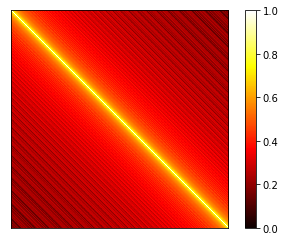

In [140]:
# Visualize Positional Embedding
pos_emb = model.decoder.embed_positions.weights.cpu().detach()
n = pos_emb.shape[0]
d = pos_emb.shape[1]
patches = []

for i in range(n):
    for j in range(n):
        patches.append(F.cosine_similarity(pos_emb[i], pos_emb[j], dim=0).detach().cpu().numpy())
        
plt.xticks([])
plt.yticks([])
plt.imshow(np.array(patches).reshape(n, n), cmap='hot', interpolation='nearest')
plt.colorbar()

79100


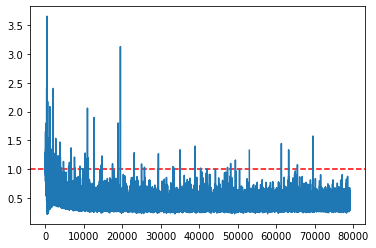

In [51]:
# Visualize Gradient Norm
print(len(grad_norm))
plt.axhline(1, color='r', linestyle='--')
plt.plot(np.arange(len(grad_norm)), grad_norm)

In [50]:
# raise

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted_zh_corpus.deduped.gz"
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

### Binarize

use fairseq to binarize data

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [ ]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: do prediction on split='mono' to create prediction_file
# generate_prediction( ... ,split=... ,outfile=... )

### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [ ]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: use fairseq to binarize these two files again
# binpath = Path('./DATA/data-bin/synthetic')
# src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
# tgt_dict_file = src_dict_file
# monopref = ./DATA/rawdata/mono/mono.tok # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess\
#         --source-lang 'zh'\
#         --target-lang 'en'\
#         --trainpref {monopref}\
#         --destdir {binpath}\
#         --srcdict {src_dict_file}\
#         --tgtdict {tgt_dict_file}\
#         --workers 2

In [ ]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb